# Project : Cancer Class Analysis

In [291]:
#importing the packages which are used in this project.
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import time
import warnings
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB , MultinomialNB
from sklearn.metrics import accuracy_score , confusion_matrix , log_loss , normalized_mutual_info_score
from sklearn.linear_model import SGDClassifier , LogisticRegression
from imblearn.over_sampling import SMOTE
from collections import Counter , defaultdict
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
#from sklearn.model_selection import StatifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
import math
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [292]:
#import 2 dataset.
dataset1 = pd.read_csv('training_variants.csv')
dataset2 = pd.read_csv('training_text.csv' , sep = "\|\|" , names = ["ID" , "TEXT"] , skiprows = 1 , engine = 'python')

In [293]:
dataset1.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [294]:
dataset2.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,"""3",Recent evidence has demonstrated that acquired...
4,"""4",Oncogenic mutations in the monomeric Casitas B...


In [295]:
dataset1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [296]:
dataset1.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [297]:
dataset1.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

In [298]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null object
TEXT    3321 non-null object
dtypes: object(2)
memory usage: 52.0+ KB


In [299]:
dataset2.describe()

,ID,TEXT
count,3321,3321
unique,3321,1473
top,2351,The PTEN (phosphatase and tensin homolog) phos...
freq,1,62


In [300]:
dataset2.isnull().sum()

ID      0
TEXT    0
dtype: int64

In [301]:
print(dataset1.shape)

(3321, 4)


In [302]:
print(dataset1.columns)

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')


In [303]:
print(dataset2.shape)
print(dataset2.columns)

(3321, 2)
Index(['ID', 'TEXT'], dtype='object')


This is mainly a Classification problem.The next step is for checking the type of classification.

In [304]:
#check how many unique values in output.
np.unique(dataset1['Class'])

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

From the above output we can assume that it is not a Binary classification.It is a Multiclass classification problem.


This a medical related problem,so correct result are very important.We might not be much bothered about time taken by Machine Learning algorithm as far it is reasonable.


We have a huge amount of TEXT data.So at first we need to pre-process it.

In [305]:
#In-text part, there are some words that are not relevant to the work.
#Removing all irrelevant word using nltk library.
stop_words = set(stopwords.words('english'))

In [306]:
def data_text_preprocessing(all_text , ind , col):
    if type(all_text) is not int:
        string = ""
    
        #Replace all special character with space
        all_text = re.sub('[^a-zA-Z0-9\n]' , ' ' , str(all_text))

        #Replace double space with single space.
        all_text = re.sub('\s+' , ' ' , str(all_text))
        
        all_text = all_text.lower()

        for word in all_text.split():
            #if the word is not stop word then take that word.
            if not word in stop_words:
                string +=word + " "

        dataset2[col][ind] = string

In [307]:
for index , row in dataset2.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocessing(row['TEXT'] , index , 'TEXT')


In [308]:
dataset2.head()

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,"""3",recent evidence demonstrated acquired uniparen...
4,"""4",oncogenic mutations monomeric casitas b lineag...


In [309]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null object
TEXT    3321 non-null object
dtypes: object(2)
memory usage: 52.0+ KB


In [310]:
'''def data_id_preprocess(total_text, ind, col):
    # Remove int values from text data as that might not be imp
    if type(total_text) is not int:
        string = ""
        # replacing all special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        # replacing multiple spaces with single space
        total_text = re.sub('\s+',' ', str(total_text))
        # bring whole text to same lower-case scale.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        dataset2[col][ind] = string
        
        
for index, row in dataset2.iterrows():
    if type(row['ID']) is str:
        data_id_preprocess(row['ID'], index, 'ID')'''

'def data_id_preprocess(total_text, ind, col):\n    # Remove int values from text data as that might not be imp\n    if type(total_text) is not int:\n        string = ""\n        # replacing all special char with space\n        total_text = re.sub(\'[^a-zA-Z0-9\n]\', \' \', str(total_text))\n        # replacing multiple spaces with single space\n        total_text = re.sub(\'\\s+\',\' \', str(total_text))\n        # bring whole text to same lower-case scale.\n        total_text = total_text.lower()\n        \n        for word in total_text.split():\n        # if the word is a not a stop word then retain that word from text\n            if not word in stop_words:\n                string += word + " "\n        \n        dataset2[col][ind] = string\n        \n        \nfor index, row in dataset2.iterrows():\n    if type(row[\'ID\']) is str:\n        data_id_preprocess(row[\'ID\'], index, \'ID\')'

In [311]:
dataset2.head()

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,"""3",recent evidence demonstrated acquired uniparen...
4,"""4",oncogenic mutations monomeric casitas b lineag...


In [312]:
#result = pd.merge(dataset1 , dataset2 , on = 'ID' ,  how = 'left')
#result.head()

In [313]:
dataset = pd.concat([dataset1 , dataset2] , axis = 1)

In [314]:
#Delete a extra ID column.
r1 = dataset.iloc[:,:4]
r2 = dataset['TEXT']

new_dataset = pd.concat([r1 , r2] , axis = 1)

In [315]:
new_dataset.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [316]:
new_dataset[new_dataset.isnull().any(axis = 1)]

,ID,Gene,Variation,Class,TEXT


In [317]:
new_dataset.loc[new_dataset['TEXT'].isnull(),'TEXT'] = new_dataset['Gene'] +' '+new_dataset['Variation']

In [318]:
new_dataset[new_dataset.isnull().any(axis = 1)]

,ID,Gene,Variation,Class,TEXT


# Spliting Dataset into Train,Test and validation

In [319]:
#Before spliting the dataset,replace SPCAE by '_' in gene and variation  
new_dataset.Gene = new_dataset.Gene.str.replace('\s+' , '_')
new_dataset.Variation = new_dataset.Variation.str.replace('\s+' , '_')

Now split the dataset into train and test.

In [320]:
y = new_dataset['Class'].values

In [321]:
#spiliting the dataset into train and test from original dataset.
x_train , test_df , y_train , y_test = train_test_split(new_dataset , y , stratify = y , test_size=0.2)

#split the dataset into train validation and cross_validation from training part
train_df , cv_df , y_train , y_cv = train_test_split(x_train , y_train , stratify = y_train , test_size=0.2)

In [322]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


Find the distribution among train,test and validation part.

In [323]:
train_distribution = train_df['Class'].value_counts().sort_index()
test_distribution = test_df['Class'].value_counts().sort_index()
validation_distribution = cv_df['Class'].value_counts().sort_index()

In [324]:
train_distribution

1    363
2    289
3     57
4    439
5    155
6    176
7    609
8     12
9     24
Name: Class, dtype: int64

The upper value is indicating the each class and their own value.Now plot this value on graph for better understanding.

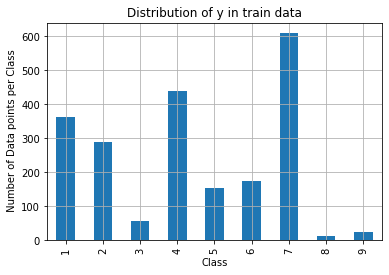

In [325]:
my_colors = 'rgkyc'
train_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of y in train data')
plt.grid()
plt.show()

In [326]:
#Showing the distriurion using percentange.
sort_y_train = np.argsort(-train_distribution.values)
for i in sort_y_train:
    print('Number of data points in class', i+1, ':',train_distribution.values[i], '(', np.round((train_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


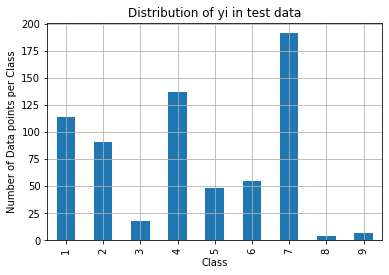

In [327]:
#Visualize test data
#my_colors = 'rgbkymc'
test_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

In [328]:
sort_y_test = np.argsort(-test_distribution.values)
for i in sort_y_test:
    print('Number of data points in class', i+1, ':',test_distribution.values[i], '(', np.round((test_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


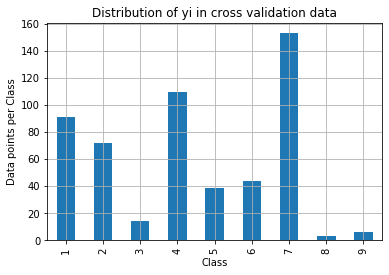

In [329]:
my_colors = 'rgbkymc'
validation_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

In [330]:
sort_y_validation = np.argsort(-validation_distribution.values)
for i in sort_y_validation:
    print('Number of data points in class', i+1, ':',validation_distribution.values[i], '(', np.round((validation_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


# Building a Random Model

In [331]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

In [332]:
#Cross validation set error
cv_predicted_y = np.zeros((cv_data_len , 9))
for i in range(cv_data_len):
    rand_proba = np.random.rand(1 , 9)
    cv_predicted_y[i] = (rand_proba/sum(sum(rand_proba)))[0]

print("Log loss on cross validation using random model" , log_loss(y_cv , cv_predicted_y , eps = 1e-15))

Log loss on cross validation using random model 2.473466493089971


In [333]:
#Test set error
test_predicted_y = np.zeros((test_data_len , 9))
for i in range(test_data_len):
    rand_proba = np.random.rand(1 , 9)
    test_predicted_y[i] = (rand_proba/sum(sum(rand_proba)))[0]

print("Log loss on cross validation using random model" , log_loss(y_test , test_predicted_y , eps = 1e-15))

Log loss on cross validation using random model 2.4550200702331875


In [334]:
# Lets get the index of max probablity
predicted_y = np.argmax(test_predicted_y , axis = 1)

In [335]:
predicted_y

array([8, 5, 4, 7, 7, 1, 5, 1, 4, 7, 0, 0, 2, 3, 5, 5, 0, 3, 4, 2, 7, 6,
       8, 4, 7, 2, 2, 1, 6, 3, 0, 2, 2, 2, 7, 4, 4, 7, 0, 8, 2, 6, 1, 0,
       5, 2, 7, 5, 1, 1, 7, 7, 7, 8, 0, 6, 1, 8, 6, 3, 1, 1, 6, 5, 3, 7,
       7, 8, 1, 6, 0, 6, 1, 4, 2, 1, 7, 4, 1, 4, 3, 6, 7, 8, 5, 7, 7, 7,
       3, 8, 8, 8, 2, 2, 0, 3, 8, 2, 4, 6, 1, 1, 5, 6, 1, 8, 6, 7, 7, 2,
       5, 4, 4, 4, 2, 5, 5, 5, 0, 4, 5, 8, 4, 3, 7, 2, 1, 8, 2, 2, 1, 5,
       1, 1, 8, 8, 3, 1, 7, 3, 1, 6, 1, 0, 0, 4, 8, 2, 1, 2, 8, 2, 2, 5,
       4, 8, 1, 7, 2, 3, 1, 7, 7, 8, 7, 1, 3, 1, 0, 7, 4, 7, 4, 2, 8, 0,
       1, 5, 5, 2, 4, 2, 0, 2, 2, 2, 0, 1, 4, 4, 7, 3, 6, 7, 4, 2, 8, 0,
       0, 7, 6, 2, 7, 7, 8, 7, 1, 5, 7, 7, 5, 4, 1, 7, 8, 1, 2, 0, 8, 7,
       3, 3, 7, 7, 2, 6, 5, 3, 7, 7, 4, 4, 8, 8, 7, 5, 6, 7, 5, 7, 7, 6,
       5, 6, 5, 0, 1, 5, 2, 4, 1, 5, 1, 6, 8, 8, 5, 3, 1, 3, 7, 8, 1, 4,
       7, 5, 6, 6, 4, 4, 3, 5, 3, 6, 2, 7, 3, 0, 5, 4, 7, 0, 7, 0, 8, 4,
       3, 8, 3, 5, 0, 6, 5, 3, 7, 1, 1, 1, 4, 4, 1,

In [336]:
predicted_y = predicted_y + 1
predicted_y

array([9, 6, 5, 8, 8, 2, 6, 2, 5, 8, 1, 1, 3, 4, 6, 6, 1, 4, 5, 3, 8, 7,
       9, 5, 8, 3, 3, 2, 7, 4, 1, 3, 3, 3, 8, 5, 5, 8, 1, 9, 3, 7, 2, 1,
       6, 3, 8, 6, 2, 2, 8, 8, 8, 9, 1, 7, 2, 9, 7, 4, 2, 2, 7, 6, 4, 8,
       8, 9, 2, 7, 1, 7, 2, 5, 3, 2, 8, 5, 2, 5, 4, 7, 8, 9, 6, 8, 8, 8,
       4, 9, 9, 9, 3, 3, 1, 4, 9, 3, 5, 7, 2, 2, 6, 7, 2, 9, 7, 8, 8, 3,
       6, 5, 5, 5, 3, 6, 6, 6, 1, 5, 6, 9, 5, 4, 8, 3, 2, 9, 3, 3, 2, 6,
       2, 2, 9, 9, 4, 2, 8, 4, 2, 7, 2, 1, 1, 5, 9, 3, 2, 3, 9, 3, 3, 6,
       5, 9, 2, 8, 3, 4, 2, 8, 8, 9, 8, 2, 4, 2, 1, 8, 5, 8, 5, 3, 9, 1,
       2, 6, 6, 3, 5, 3, 1, 3, 3, 3, 1, 2, 5, 5, 8, 4, 7, 8, 5, 3, 9, 1,
       1, 8, 7, 3, 8, 8, 9, 8, 2, 6, 8, 8, 6, 5, 2, 8, 9, 2, 3, 1, 9, 8,
       4, 4, 8, 8, 3, 7, 6, 4, 8, 8, 5, 5, 9, 9, 8, 6, 7, 8, 6, 8, 8, 7,
       6, 7, 6, 1, 2, 6, 3, 5, 2, 6, 2, 7, 9, 9, 6, 4, 2, 4, 8, 9, 2, 5,
       8, 6, 7, 7, 5, 5, 4, 6, 4, 7, 3, 8, 4, 1, 6, 5, 8, 1, 8, 1, 9, 5,
       4, 9, 4, 6, 1, 7, 6, 4, 8, 2, 2, 2, 5, 5, 2,

# Confusion-Matrix

In [337]:
c = confusion_matrix(y_test , predicted_y)

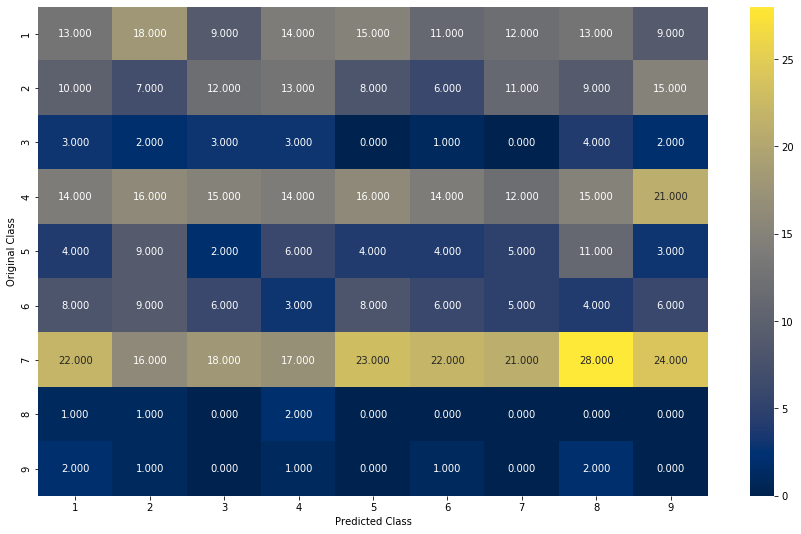

In [338]:
labels = [1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9]
plt.figure(figsize = (15 , 9))
sns.heatmap(c , annot = True , cmap = 'cividis' , fmt = ".3f" , xticklabels = labels , yticklabels = labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

# Precision Matrix

In [339]:
pm =(c/c.sum(axis=0))

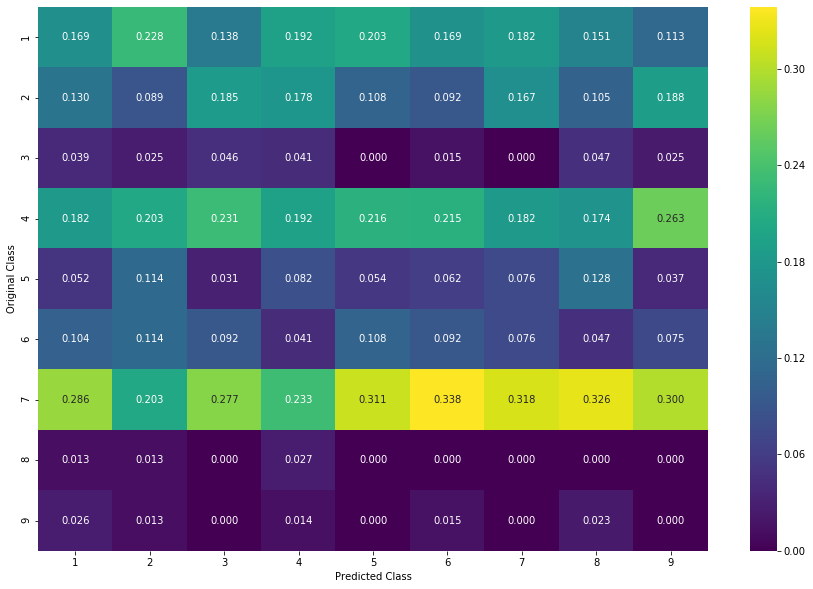

In [340]:
plt.figure(figsize=(15 , 10))
sns.heatmap(pm, annot=True, cmap="viridis", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

# Recall Matrix

In [341]:
rm =(((c.T)/(c.sum(axis=1))).T)

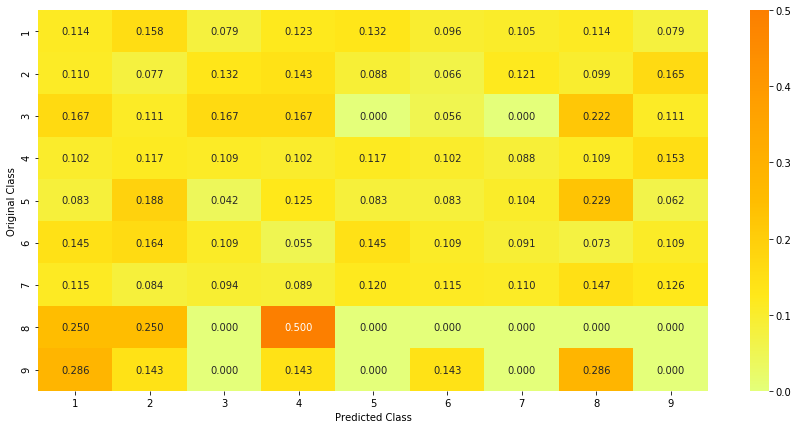

In [342]:
plt.figure(figsize=(15 , 7))
sns.heatmap(rm, annot=True, cmap="Wistia", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

# Analysis Every column.

Now analysis every single column to find out it is relavent to targert column.

### Evaluting Gene column#

In [343]:
unqe_gene = train_df['Gene'].value_counts()
print(unqe_gene.head(10))

BRCA1    164
TP53     103
EGFR      90
BRCA2     77
PTEN      76
KIT       66
BRAF      63
ERBB2     48
ALK       42
FGFR2     38
Name: Gene, dtype: int64


In [344]:
unqe_gene.shape[0]

239

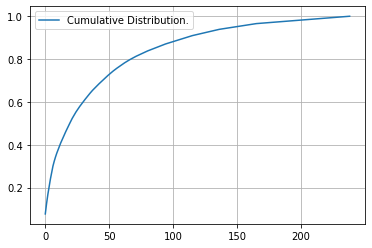

In [345]:
#plot the value on graph.
s = sum(unqe_gene.values)
h = unqe_gene.values/s
c = np.cumsum(h)
plt.plot(c , label = 'Cumulative Distribution.')
plt.legend()
plt.grid()
plt.show()

We can see that 50 gene have the value around 75%.So now convert the categorical value into numerical value.We use 2 technique.

1.One-Hot-Encoding

2.Response-Encoding

In [346]:
#using one hot encoding.
vec_gene = CountVectorizer()
train_gene_hot_encoding = vec_gene.fit_transform(train_df['Gene'])
test_gene_hot_encoding = vec_gene.transform(test_df['Gene'])
cv_gene_hot_encoding = vec_gene.transform(cv_df['Gene'])

In [347]:
train_gene_hot_encoding.shape

(2124, 238)

In [348]:
test_gene_hot_encoding.shape

(665, 238)

In [349]:
cv_gene_hot_encoding.shape

(532, 238)

This is one the main problem of one-hot-encoding.It creates more dimension on dataset.Some algorithm work very bad on high dimension dataset.In train part it creates 227 column.Let's see the columns.

In [350]:
vec_gene.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'atm',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxl2',
 'foxp1',
 'gata3',
 'gli1',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikzf1',
 'il7r',
 

Now,convert the categorical value with response encoding.

In [351]:
def gene_variation(alpha , feature , df):
    
    #count the each gene value
    value_count = train_df[feature].value_counts()
    
    gv_dict = dict()
    
    for i , denominator in value_count.items():
        
        #create a 9-dimensional vector
        vec = []
        
        for k in range(1 , 10):
            #save the unique gene and with respect to it's class
            cls_count = train_df.loc[(train_df['Class'] == k) & (train_df[feature] == i)]
            
            #it means that a particular value how many times occured.
            vec.append((cls_count.shape[0] + alpha * 10)/ (denominator + 90 * alpha))
            
        gv_dict[i] = vec
    return gv_dict
            
            
def convert_toResponseEncoding(alpha , feature , df):
    
    #get the gene variation feature
    g_dict = gene_variation(alpha , feature , df)
    
    #count the value of each gene
    value_count = train_df[feature].value_counts()
    
    gv_fea = []
    
    #for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(g_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

In [352]:
# alpha is used for laplace smoothing
alpha = 1

# train gene 
train_gene_responseCoding = np.array(convert_toResponseEncoding(alpha , "Gene" , train_df))

# test gene 
test_gene_responseCoding = np.array(convert_toResponseEncoding(alpha , "Gene" , test_df))

# cross validation gene 
cv_gene_responsecoding = np.array(convert_toResponseEncoding(alpha , "Gene" , cv_df))

In [353]:
train_gene_responseCoding.shape

(2124, 9)

Now we make a model with only one column gene.First we use one hot encoding for the model then response encoding.Then find out the which log-loss is lesser than the random model.

In [354]:
#Hyper-parameter for SGDclassifier.
alpha = [10 ** x for x in range(-5, 1)]

In [355]:
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1]

In [356]:
#we use SGDClassifier and also CalibratedClassifier for probabilistic output.
cv_log_loss = []
for i in alpha:
    sgd = SGDClassifier(alpha = i , penalty = 'l2' , loss = 'log' , random_state = 42)
    sgd.fit(train_gene_hot_encoding , y_train)
    
    ccv = CalibratedClassifierCV(sgd , method = 'sigmoid')
    ccv.fit(train_gene_hot_encoding , y_train)
    
    predicted_ccv = ccv.predict_proba(cv_gene_hot_encoding)
    
    cv_log_loss.append(log_loss(y_cv , predicted_ccv , labels = sgd.classes_ , eps = 1e-15))
    print("alpha = " , i , "Log-Loss: ",log_loss(y_cv , predicted_ccv , labels = sgd.classes_ , eps = 1e-15))

alpha =  1e-05 Log-Loss:  1.1955809344292172
alpha =  0.0001 Log-Loss:  1.1665571869400948
alpha =  0.001 Log-Loss:  1.2007666766998881
alpha =  0.01 Log-Loss:  1.3029928089329474
alpha =  0.1 Log-Loss:  1.395294551962515
alpha =  1 Log-Loss:  1.4424731434750144


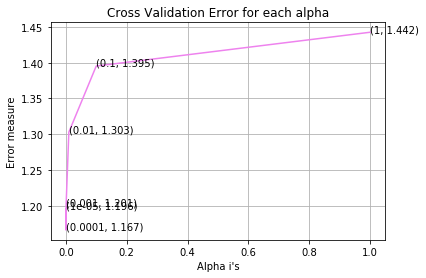

In [357]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_loss , c='violet')
for i, txt in enumerate(np.round(cv_log_loss,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_loss[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

Do the same work for response-encoding.

In [358]:
#we use SGDClassifier and also CalibratedClassifier for probabilistic output with respone-encoding
cv_log_loss_response_encoding = []
for i in alpha:
    sgd = SGDClassifier(alpha = i , penalty = 'l2' , loss = 'log' , random_state = 42)
    sgd.fit(train_gene_responseCoding , y_train)
    
    ccv = CalibratedClassifierCV(sgd , method = 'sigmoid')
    ccv.fit(train_gene_responseCoding , y_train)
    
    predicted_ccv = ccv.predict_proba(cv_gene_responsecoding )
    
    cv_log_loss_response_encoding.append(log_loss(y_cv , predicted_ccv , labels = sgd.classes_ , eps = 1e-15))
    print("alpha = " , i , "Log-Loss: ",log_loss(y_cv , predicted_ccv , labels = sgd.classes_ , eps = 1e-15))

alpha =  1e-05 Log-Loss:  1.225730340461059
alpha =  0.0001 Log-Loss:  1.2612371089450993
alpha =  0.001 Log-Loss:  1.337523766561972
alpha =  0.01 Log-Loss:  1.372338389472614
alpha =  0.1 Log-Loss:  1.3798896293469187
alpha =  1 Log-Loss:  1.3829285495343915


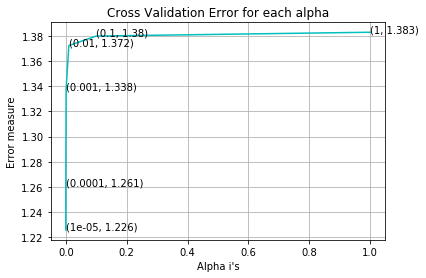

In [359]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha , cv_log_loss_response_encoding , c = 'c')
for i, txt in enumerate(np.round(cv_log_loss_response_encoding , 3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_loss_response_encoding[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [360]:
#From the graph we can now use the best alpha value and compute the log loss
best_alpha = np.argmin(cv_log_loss_response_encoding)
best_alpha

0

In [361]:
sgd = SGDClassifier(alpha=alpha[best_alpha] , penalty='l2', loss='log', random_state=42)
sgd.fit(train_gene_responseCoding, y_train)

ccv = CalibratedClassifierCV(sgd, method="sigmoid")
ccv.fit(train_gene_responseCoding, y_train)

predict_ccv_train = ccv.predict_proba(train_gene_responseCoding)
print('Values of alpha = ',alpha[best_alpha]  , 'Training log loss is: ', log_loss(y_train , predict_ccv_train , labels = sgd.classes_ , eps = 1e-15))

predict_ccv_test = ccv.predict_proba(test_gene_responseCoding)
print('Values of alpha = ',alpha[best_alpha] , 'Training log loss is: ', log_loss(y_test , predict_ccv_test , labels = sgd.classes_ , eps = 1e-15))

predict_ccv_cv = ccv.predict_proba(cv_gene_responsecoding)
print('Values of alpha = ',alpha[best_alpha]  , 'Training log loss is: ', log_loss(y_cv , predict_ccv_cv , labels = sgd.classes_ , eps = 1e-15))

Values of alpha =  1e-05 Training log loss is:  1.2004457135046247
Values of alpha =  1e-05 Training log loss is:  1.236064678466746
Values of alpha =  1e-05 Training log loss is:  1.225730340461059


Checking the overlapping.

In [362]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [363]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 648 out of 665 : 97.44360902255639
2. In cross validation data 520 out of  532 : 97.74436090225564


### Working with variation column.

Again we use one hot encoder and response encoding for variation column.

In [364]:
unique_value_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_value_variations.shape[0])
print(unique_value_variations.head(10))

Number of Unique Variations : 1930
Truncating_Mutations    64
Deletion                47
Amplification           44
Fusions                 23
Overexpression           4
G12V                     3
Y64A                     2
S222D                    2
G35R                     2
Q61R                     2
Name: Variation, dtype: int64


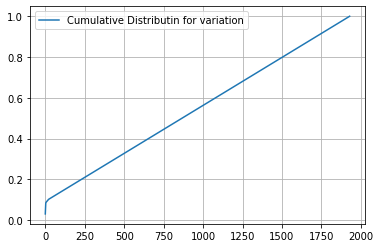

In [365]:
#Let's see this on graph.
s = sum(unique_value_variations.values)
h = unique_value_variations.values / s
c = np.cumsum(h)
plt.plot(c , label = 'Cumulative Distributin for variation')
plt.legend()
plt.grid()
plt.show()

From the above graph and the value_count it is sure that,the distribution is not properly well.

In [366]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [367]:
train_variation_onehotCoding.shape

(2124, 1956)

In [368]:
test_variation_onehotCoding.shape

(665, 1956)

In [369]:
cv_variation_onehotCoding.shape

(532, 1956)

In [370]:
variation_vectorizer.get_feature_names()

['126',
 '1_2009trunc',
 '1_fusion',
 '2010_2471trunc',
 '256_286trunc',
 '385_418del',
 '422_605trunc',
 '51',
 '533_534del',
 '534_536del',
 '550_592del',
 '560_561inser',
 '963_d1010splice',
 '_fusion',
 'a1022e',
 'a1065t',
 'a1066v',
 'a111p',
 'a113_splice',
 'a1170v',
 'a11_g12insga',
 'a1200v',
 'a120s',
 'a121p',
 'a122',
 'a126g',
 'a126s',
 'a126v',
 'a134d',
 'a1374v',
 'a1459p',
 'a146t',
 'a146v',
 'a151t',
 'a161s',
 'a161t',
 'a1669s',
 'a1685s',
 'a1701p',
 'a171v',
 'a1789s',
 'a1823t',
 'a1830t',
 'a1843p',
 'a197t',
 'a19v',
 'a2034v',
 'a205t',
 'a209t',
 'a211d',
 'a232v',
 'a23e',
 'a246p',
 'a263v',
 'a2643g',
 'a272v',
 'a2770t',
 'a290t',
 'a298t',
 'a347t',
 'a349p',
 'a36p',
 'a40e',
 'a4419s',
 'a459v',
 'a500t',
 'a502_y503dup',
 'a504_y505ins',
 'a530t',
 'a530v',
 'a546d',
 'a57v',
 'a598t',
 'a598v',
 'a59g',
 'a60v',
 'a614d',
 'a627t',
 'a633t',
 'a634d',
 'a636p',
 'a648t',
 'a727v',
 'a728v',
 'a72s',
 'a72v',
 'a750_e758del',
 'a750_e758delinsp',
 

In [371]:
# Response Encoding
alpha = 1

# train gene 
train_variation_responseCoding = np.array(convert_toResponseEncoding(alpha , "Variation" , train_df))

# test gene 
test_variation_responseCoding = np.array(convert_toResponseEncoding(alpha , "Variation" , test_df))

# cross validation gene 
cv_variation_responseCoding = np.array(convert_toResponseEncoding(alpha , "Variation" , cv_df))

In [372]:
train_variation_responseCoding.shape

(2124, 9)

In [373]:
test_variation_responseCoding.shape

(665, 9)

In [374]:
cv_variation_responseCoding.shape

(532, 9)

In [375]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1]

In [376]:
#Use SGDClassifier and calibratedClassifier on one-hot-encoder.
cv_log_error_variation = []
for i in alpha:
    sgd_variation = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sgd_variation.fit(train_variation_onehotCoding, y_train)
    
    ccv_variation = CalibratedClassifierCV(sgd_variation, method="sigmoid")
    ccv_variation.fit(train_variation_onehotCoding, y_train)
    
    predict_variation = ccv_variation.predict_proba(cv_variation_onehotCoding)
    
    cv_log_error_variation.append(log_loss(y_cv, predict_variation, labels=sgd_variation.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv , predict_variation , labels=sgd_variation.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.7122749232389112
For values of alpha =  0.0001 The log loss is: 1.7050176894917097
For values of alpha =  0.001 The log loss is: 1.7071607727312392
For values of alpha =  0.01 The log loss is: 1.7180338249347848
For values of alpha =  0.1 The log loss is: 1.7308218710912873
For values of alpha =  1 The log loss is: 1.730984910022942


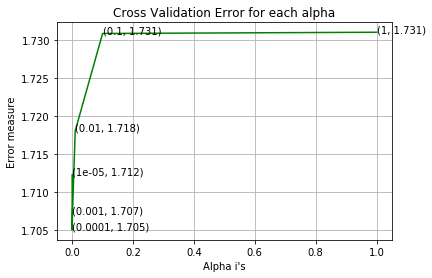

In [377]:
fig, ax = plt.subplots()
ax.plot(alpha , cv_log_error_variation , c = 'g')
for i, txt in enumerate(np.round(cv_log_error_variation , 3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_variation[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [378]:
#Find the best alpha.now put that value on classifier.
best_alpha = np.argmin(cv_log_error_variation)

sgd_variation = SGDClassifier(alpha=alpha[best_alpha] , penalty='l2', loss='log', random_state=42)
sgd_variation.fit(train_variation_onehotCoding, y_train)

ccv = CalibratedClassifierCV(sgd_variation , method="sigmoid")
ccv.fit(train_variation_onehotCoding, y_train)

predict_ccv_train = ccv.predict_proba(train_variation_onehotCoding)
print('Values of alpha = ',alpha[best_alpha]  , 'Training log loss is: ', log_loss(y_train , predict_ccv_train , labels = sgd.classes_ , eps = 1e-15))

predict_ccv_test = ccv.predict_proba(test_variation_onehotCoding)
print('Values of alpha = ',alpha[best_alpha] , 'Training log loss is: ', log_loss(y_test , predict_ccv_test , labels = sgd.classes_ , eps = 1e-15))

predict_ccv_cv = ccv.predict_proba(cv_variation_onehotCoding)
print('Values of alpha = ',alpha[best_alpha]  , 'Training log loss is: ', log_loss(y_cv , predict_ccv_cv , labels = sgd.classes_ , eps = 1e-15))

Values of alpha =  0.0001 Training log loss is:  0.6284830956035042
Values of alpha =  0.0001 Training log loss is:  1.7086860826841506
Values of alpha =  0.0001 Training log loss is:  1.7050176894917097


In [379]:
test_coverage = test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage = cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

In [380]:
print('In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

In test data 71 out of 665 : 10.676691729323307
In cross validation data 56 out of  532 : 10.526315789473683


Now apply Same method on Response encoding

In [381]:
#Use SGDClassifier and calibratedClassifier Response Encoding.
cv_log_error_variation_re = []
for i in alpha:
    sgd_variation_re = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sgd_variation_re.fit(train_variation_responseCoding, y_train)
    
    ccv_variation_re = CalibratedClassifierCV(sgd_variation_re , method = "sigmoid")
    ccv_variation_re.fit(train_variation_responseCoding, y_train)
    
    predict_variation_re = ccv_variation_re.predict_proba(cv_variation_responseCoding)
    
    cv_log_error_variation_re.append(log_loss(y_cv, predict_variation_re, labels=sgd_variation.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv , predict_variation_re , labels=sgd_variation.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 2.037883245006289
For values of alpha =  0.0001 The log loss is: 1.9489024782070916
For values of alpha =  0.001 The log loss is: 1.8426489463464855
For values of alpha =  0.01 The log loss is: 1.8297088436538136
For values of alpha =  0.1 The log loss is: 1.8252197723463608
For values of alpha =  1 The log loss is: 1.7647322289417082


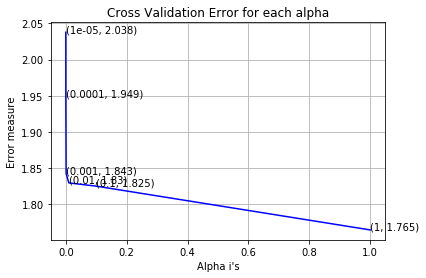

In [382]:
fig, ax = plt.subplots()
ax.plot(alpha , cv_log_error_variation_re , c='b')
for i, txt in enumerate(np.round(cv_log_error_variation_re , 3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i] , cv_log_error_variation_re[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [383]:
#Find the best alpha.now put that value on classifier.
best_alpha = np.argmin(cv_log_error_variation_re)

sgd_variation = SGDClassifier(alpha = alpha[best_alpha] , penalty='l2', loss='log', random_state=42)
sgd_variation.fit(train_variation_responseCoding, y_train)

ccv = CalibratedClassifierCV(sgd_variation , method="sigmoid")
ccv.fit(train_variation_responseCoding, y_train)

predict_ccv_train = ccv.predict_proba(train_variation_responseCoding)
print('Values of alpha = ',alpha[best_alpha]  , 'Training log loss is: ', log_loss(y_train , predict_ccv_train , labels = sgd.classes_ , eps = 1e-15))

predict_ccv_test = ccv.predict_proba(test_variation_responseCoding)
print('Values of alpha = ',alpha[best_alpha] , 'Training log loss is: ', log_loss(y_test , predict_ccv_test , labels = sgd.classes_ , eps = 1e-15))

predict_ccv_cv = ccv.predict_proba(cv_variation_responseCoding)
print('Values of alpha = ',alpha[best_alpha]  , 'Training log loss is: ', log_loss(y_cv , predict_ccv_cv , labels = sgd.classes_ , eps = 1e-15))

Values of alpha =  1 Training log loss is:  1.0130991317818114
Values of alpha =  1 Training log loss is:  1.7734507735298988
Values of alpha =  1 Training log loss is:  1.7647322289417082


In [384]:
test_coverage = test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage = cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

In [385]:
print('In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

In test data 71 out of 665 : 10.676691729323307
In cross validation data 56 out of  532 : 10.526315789473683


### Working with Text column

In [386]:
#Find the unique word and save it on a dict.
def extract_dict(cls_text):
    dictionary = defaultdict(int) #if there is no matching value then also defaultdict can run.
    for index , row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] += 1
    return dictionary

In [387]:
def get_text_ResponseCoding(df):
    text_feature_responsecoding = np.zeros((df.shape[0] , 9))
    for i in range(0 , 9):
        row_index = 0
        for index , row in df.iterrows():
            sum_prb = 0
            for word in row['TEXT'].split():
                sum_prb += math.log(((dict_list[i].get(word , 0) + 10)/(total_dict.get(word , 0)+90)))
            
            text_feature_responsecoding[row_index][i] = math.exp(sum_prb/len(row['TEXT'].split()))
            row_index += 1
            
    return text_feature_responsecoding

In [388]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df = 3)

train_text_onehotencoding = text_vectorizer.fit_transform(train_df['TEXT'])

#all the features name
train_text_features = text_vectorizer.get_feature_names()

#count the number of each word occurance.
train_text_features_counts = train_text_onehotencoding.sum(axis = 0).A1

text_dict = dict(zip(list(train_text_features) , train_text_features_counts))

print("Total number of unique word in train data: ",len(train_text_features))

Total number of unique word in train data:  19322


In [389]:
text_dict

{'00': 211,
 '000': 1463,
 '0000001': 3,
 '000001': 6,
 '000007': 5,
 '00001': 3,
 '000011': 5,
 '0000112': 3,
 '000012': 5,
 '0000208': 6,
 '00005': 5,
 '0000614': 6,
 '0000645': 3,
 '00006559': 3,
 '0000839': 3,
 '0001': 222,
 '0001042': 6,
 '0001171': 3,
 '0002': 11,
 '0002050': 3,
 '0002079': 3,
 '0002158': 7,
 '00025': 3,
 '0003': 7,
 '0003073': 3,
 '0003254': 3,
 '00034': 3,
 '0003529': 3,
 '00037': 3,
 '0004376': 3,
 '0004798': 3,
 '0004920': 3,
 '0005': 10,
 '0005044': 3,
 '0005159': 3,
 '0005214': 3,
 '0005266': 3,
 '0005309': 3,
 '0005355': 3,
 '000548': 45,
 '0006': 6,
 '0007': 3,
 '0008': 7,
 '00092': 3,
 '000g': 7,
 '001': 419,
 '0010': 3,
 '0013': 3,
 '0014': 6,
 '0016': 4,
 '0018': 3,
 '001acd4': 6,
 '001acd8': 3,
 '001bathe': 3,
 '001bimmunophenotypecd34': 3,
 '001blyl1': 3,
 '002': 69,
 '002755': 10,
 '003': 60,
 '0032': 3,
 '003797': 3,
 '004': 33,
 '00433': 4,
 '004333': 11,
 '004456': 3,
 '004972': 3,
 '004985': 4,
 '005': 140,
 '005228': 5,
 '005235': 5,
 '005610':

In [390]:
train_text_onehotencoding.shape

(2124, 19322)

In [391]:
dict_list = []

for i in range(1, 10):
    cls_text = train_df[train_df['Class'] == i]
    dict_list.append(extract_dict(cls_text)) #Build a word dictionary based on that word.
    
#total_dict build on whole training data.
total_dict = extract_dict(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0 , 9):
        ratios.append((dict_list[j][i] + 10) / (total_dict[i] + 90))
    confuse_array.append(ratios)
    
confuse_array = np.array(confuse_array)    

In [392]:
#response coding of text features
train_text_responseCoding  = get_text_ResponseCoding(train_df)
test_text_responseCoding  = get_text_ResponseCoding(test_df)
cv_text_responseCoding  = get_text_ResponseCoding(cv_df)

In [393]:
# we convert each row values such that they sum to 1  
train_text_responseCoding = (train_text_responseCoding.T / train_text_responseCoding.sum(axis=1)).T
test_text_responseCoding = (test_text_responseCoding.T / test_text_responseCoding.sum(axis = 1)).T
cv_text_responseCoding = (cv_text_responseCoding.T / cv_text_responseCoding.sum(axis = 1)).T

In [394]:
pd.DataFrame(train_text_responseCoding)

,0,1,2,3,4,5,6,7,8
0,0.124894,0.090254,0.047090,0.417027,0.054155,0.069066,0.151811,0.019684,0.026019
1,0.207843,0.106139,0.050931,0.158662,0.113214,0.200932,0.138703,0.008793,0.014784
2,0.188562,0.162270,0.054324,0.158168,0.070941,0.093198,0.203041,0.030886,0.038611
3,0.211754,0.123574,0.046889,0.280186,0.056084,0.096530,0.135286,0.017880,0.031817
4,0.088728,0.285791,0.041981,0.106326,0.036656,0.070753,0.347647,0.008364,0.013755
5,0.198693,0.130831,0.053091,0.209918,0.068276,0.085532,0.189576,0.026001,0.038081
6,0.190299,0.101507,0.059242,0.219918,0.092516,0.127430,0.132007,0.035178,0.041902
7,0.136390,0.191363,0.054438,0.141773,0.055222,0.070259,0.317621,0.013822,0.019111
8,0.170071,0.141165,0.053882,0.242954,0.071783,0.113379,0.169195,0.015652,0.021919
9,0.139453,0.131621,0.060119,0.189091,0.062615,0.084744,0.270760,0.018004,0.043592


In [395]:
#Normalize train features
train_text_onehotencoding = normalize(train_text_onehotencoding , axis = 0)

#normalize test feature
test_text_onehotencoding = text_vectorizer.transform(test_df['TEXT'])
test_text_onehotencoding = normalize(test_text_onehotencoding , axis = 0)

#normalize cross validation feature
cv_text_onehotencoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_onehotencoding = normalize(cv_text_onehotencoding , axis = 0)

In [396]:
train_text_onehotencoding.shape

(2124, 19322)

In [397]:
sorted_text_feature = dict(sorted(text_dict.items() , key = lambda x: x[1] , reverse = True))
sorted_text_occur = np.array(list(sorted_text_feature.values()))

In [398]:
pd.DataFrame(sorted_text_occur)

,0
0,27288
1,14930
2,13201
3,10410
4,9771
5,8985
6,8535
7,8534
8,7902
9,7868


In [399]:
print(Counter(sorted_text_occur))

Counter({3: 2191, 4: 1357, 6: 1124, 7: 827, 5: 824, 9: 733, 8: 704, 10: 515, 12: 455, 15: 388, 11: 349, 14: 331, 13: 322, 18: 291, 41: 266, 16: 265, 17: 230, 19: 221, 20: 208, 21: 196, 24: 158, 22: 157, 23: 145, 27: 144, 30: 131, 26: 130, 29: 128, 25: 127, 28: 126, 31: 109, 42: 102, 32: 100, 34: 96, 35: 95, 33: 93, 45: 92, 37: 89, 36: 88, 43: 85, 39: 81, 44: 77, 46: 71, 47: 70, 40: 70, 49: 64, 38: 64, 50: 62, 52: 61, 48: 61, 60: 60, 58: 56, 51: 56, 59: 52, 55: 52, 57: 50, 72: 48, 61: 47, 62: 44, 56: 44, 54: 44, 63: 43, 53: 43, 82: 41, 77: 36, 70: 36, 67: 36, 66: 36, 83: 35, 76: 35, 80: 34, 68: 33, 65: 33, 90: 32, 85: 31, 79: 31, 71: 31, 69: 31, 75: 30, 74: 29, 73: 29, 64: 28, 103: 27, 98: 27, 94: 27, 100: 26, 91: 26, 84: 26, 99: 25, 78: 25, 127: 23, 120: 23, 102: 23, 86: 23, 123: 22, 92: 22, 89: 22, 81: 22, 116: 21, 93: 21, 104: 20, 96: 20, 87: 20, 130: 19, 114: 19, 112: 19, 107: 19, 113: 18, 105: 18, 95: 18, 160: 17, 122: 17, 118: 17, 109: 17, 106: 17, 141: 16, 140: 16, 138: 16, 135: 

In [400]:
#build model.
cv_log_error_text = []
for i in alpha:
    sgd_text = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sgd_text.fit(train_text_onehotencoding, y_train)
    
    ccv_text = CalibratedClassifierCV(sgd_text , method = "sigmoid")
    ccv_text.fit(train_text_onehotencoding, y_train)
    
    predict_text = ccv_text.predict_proba(cv_text_onehotencoding)
    
    cv_log_error_text.append(log_loss(y_cv, predict_text, labels = sgd_text.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_text , labels = sgd_text.classes_ , eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.413370078993737
For values of alpha =  0.0001 The log loss is: 1.2866929684621677
For values of alpha =  0.001 The log loss is: 1.3706249804945134
For values of alpha =  0.01 The log loss is: 1.488881951675096
For values of alpha =  0.1 The log loss is: 1.6679773291902464
For values of alpha =  1 The log loss is: 1.7438036833034098


No handles with labels found to put in legend.


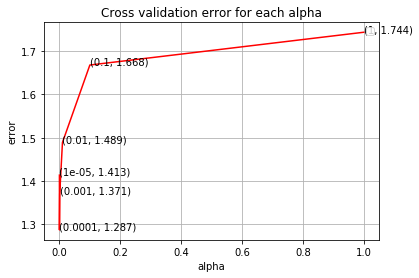

In [401]:
fig , ax = plt.subplots()
ax.plot(alpha , cv_log_error_text , c = 'r')
for i , txt in enumerate(np.round(cv_log_error_text , 3)):
    ax.annotate((alpha[i] , np.round(txt , 3)) , (alpha[i] , cv_log_error_text[i]))
plt.grid()
plt.legend()
plt.title('Cross validation error for each alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.show()

In [402]:
best_alpha = np.argmin(cv_log_error_text)

sgd_text = SGDClassifier(alpha = alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sgd_text.fit(train_text_onehotencoding, y_train)
    
ccv_text = CalibratedClassifierCV(sgd_text , method = "sigmoid")
ccv_text.fit(train_text_onehotencoding, y_train)


predict_text = ccv_text.predict_proba(train_text_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_text, labels = sgd_text.classes_, eps=1e-15))

predict_text = ccv_text.predict_proba(cv_text_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_text, labels = sgd_text.classes_, eps=1e-15))

predict_text = ccv_text.predict_proba(test_text_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_text, labels = sgd_text.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 1.085796808926886
For values of best alpha =  0.0001 The cross validation log loss is: 1.2866929684621677
For values of best alpha =  0.0001 The test log loss is: 1.3597098605488207


In [403]:
#Check the overlap test data
def check_overlaping(df):
    df_text_vc = CountVectorizer(min_df = 3)
    df_text_ft = df_text_vc.fit_transform(df['TEXT'])
    df_text_features = df_text_vc.get_feature_names()
    
    df_text_ft_counts = df_text_ft.sum(axis = 0).A1
    df_text_ft_dict = dict(zip(list(df_text_features) , df_text_ft_counts))
    
    l1 = len(set(df_text_features))
    l2 = len(set(train_text_features) & set(df_text_features))
    
    return l1 , l2

In [404]:
l1 , l2 = check_overlaping(test_df)
print(np.round((l2 / l1)*100, 3), "% of word of test data appeared in train data")

l1 , l2 = check_overlaping(cv_df)
print(np.round((l2 / l1)*100, 3), "% of word of Cross Validation appeared in train data")

96.561 % of word of test data appeared in train data
95.367 % of word of Cross Validation appeared in train data


# Data Preparation

In [405]:
def report_log_loss(train_x , train_y , test_x , test_y , df):
    df.fit(train_x , train_y)
    
    ccv_df = CalibratedClassifierCV(df , method = 'sigmoid')
    ccv_df.fit(train_x , train_y)
    
    ccv_df_probs = ccv_df.predict_proba(test_x)
    return log_loss(test_y , ccv_df_probs , eps = 1e-15)

In [524]:
def plot_confusion_matrix(test_y, predict_y):
    
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0)) 
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(15 , 9))
    sns.heatmap(C, annot=True, cmap="flag", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(15 , 9))
    sns.heatmap(B, annot=True, cmap="prism", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(15 , 9))
    sns.heatmap(A, annot=True, cmap="RdYlGn", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [481]:
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

# Combine all feature

In [408]:
# combine with one-hot-encoding
train_gene_onehotEncoding = hstack((train_gene_hot_encoding , train_variation_onehotCoding))
test_gene_onehotEncoding = hstack((test_gene_hot_encoding , test_variation_onehotCoding))
cv_gene_onehotEncoding = hstack((cv_gene_hot_encoding , cv_variation_onehotCoding))

train_x_onehotEncoding = hstack((train_gene_onehotEncoding , train_text_onehotencoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotEncoding = hstack((test_gene_onehotEncoding , test_text_onehotencoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotEncoding = hstack((cv_gene_onehotEncoding , cv_text_onehotencoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


#combine with response-coding
train_gene_responseEncoding = np.hstack((train_gene_responseCoding , train_variation_responseCoding))
test_gene_responseCoding = np.hstack((test_gene_responseCoding , test_variation_responseCoding))
cv_gene_responseCoding = np.hstack((cv_gene_responsecoding , cv_variation_responseCoding))


train_x_responseEncoding = np.hstack((train_gene_responseEncoding, train_text_responseCoding))
test_x_responseEncoding = np.hstack((test_gene_responseCoding, test_text_responseCoding))
cv_x_responseEncoding = np.hstack((cv_gene_responseCoding, cv_text_responseCoding))

In [409]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotEncoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotEncoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotEncoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 21516)
(number of data points * number of features) in test data =  (665, 21516)
(number of data points * number of features) in cross validation data = (532, 21516)


In [410]:
print("Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseEncoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseEncoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseEncoding.shape)

Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


# Applying Machine Learning Model

Now, apply different type of machine learning algorithm and find the difference among them.

1 . Logistic Regression

2 . KNN

3 . Naive Bayes

4 . SVM

5 . Random Forest

6 . Stacking Classifer

7 . AdaBoost(Boosting tecnique)

8 . XGBoost(Boosting tecnique)

# LOGISTIC REGRESSION

### Balancing all classes

##### Using One-hot-encoding

In [123]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_LR = []

for i in alpha:
    print("for alpha =", i)
    lr = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    lr.fit(train_x_onehotEncoding , train_y)
    
    ccv_lr = CalibratedClassifierCV(lr , method = "sigmoid")
    ccv_lr.fit(train_x_onehotEncoding , train_y)
    
    ccv_lr_predict = ccv_lr.predict_proba(cv_x_onehotEncoding)
    
    cv_log_error_LR.append(log_loss(cv_y, ccv_lr_predict , labels = lr.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, ccv_lr_predict)) 

for alpha = 1e-06
Log Loss : 1.521090274519836
for alpha = 1e-05
Log Loss : 1.3522587438941636
for alpha = 0.0001
Log Loss : 1.1407389859845185
for alpha = 0.001
Log Loss : 1.1632967058409323
for alpha = 0.01
Log Loss : 1.3129720983426325
for alpha = 0.1
Log Loss : 1.6205840069934916
for alpha = 1
Log Loss : 1.7158763979882425
for alpha = 10
Log Loss : 1.726064731495801
for alpha = 100
Log Loss : 1.7274237001327282


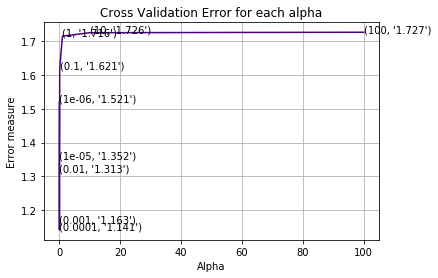

In [124]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_LR , c = 'indigo')
for i, txt in enumerate(np.round(cv_log_error_LR , 3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i] , cv_log_error_LR[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error measure")
plt.show()

In [125]:
best_alpha = np.argmin(cv_log_error_LR)

lr = SGDClassifier(class_weight='balanced', alpha = alpha[best_alpha] , penalty='l2', loss='log', random_state = 30)
lr.fit(train_x_onehotEncoding , train_y)
    
ccv_lr = CalibratedClassifierCV(lr , method = "sigmoid")
ccv_lr.fit(train_x_onehotEncoding , train_y)

predict_y_lr_train = ccv_lr.predict_proba(train_x_onehotEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train , predict_y , labels=lr.classes_, eps=1e-15))

predict_y_lr_test = ccv_lr.predict_proba(test_x_onehotEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test , predict_y, labels=lr.classes_, eps=1e-15))

predict_y_lr_cv = ccv_lr.predict_proba(cv_x_onehotEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv , predict_y, labels=lr.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.5063597810943116
For values of best alpha =  0.0001 The test log loss is: 1.0243563050991933
For values of best alpha =  0.0001 The cross validation log loss is: 1.137308110746835


Log loss : 1.137308110746835
Number of mis-classified points : 0.37030075187969924
-------------------- Confusion matrix --------------------


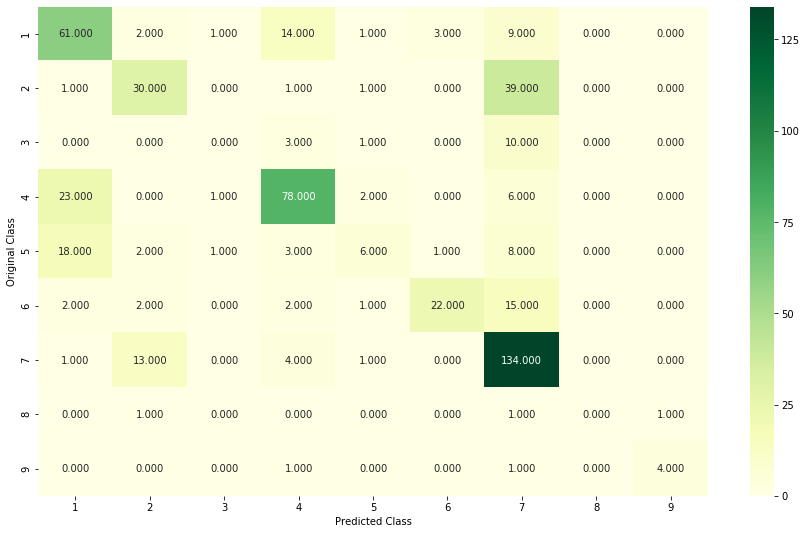

-------------------- Precision matrix (Columm Sum=1) --------------------


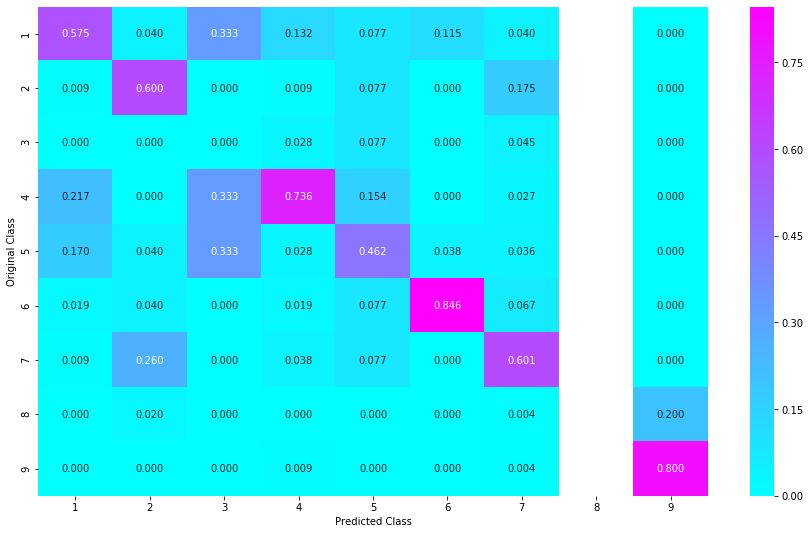

-------------------- Recall matrix (Row sum=1) --------------------


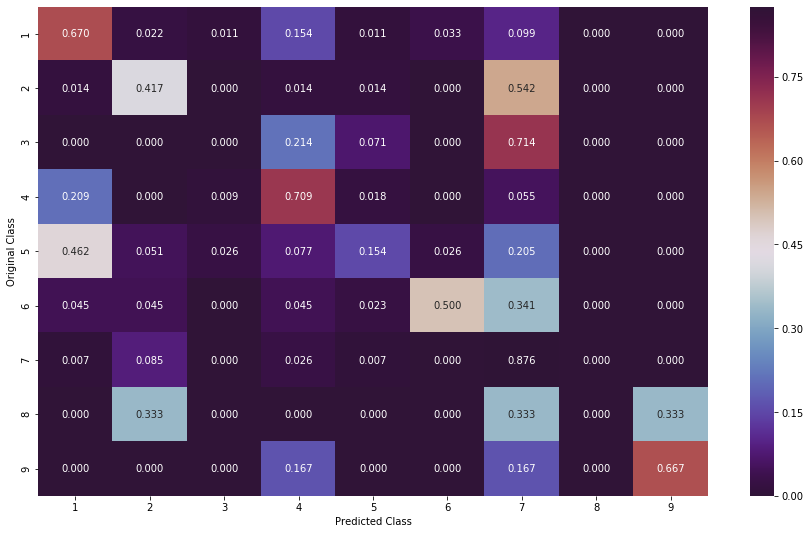

In [126]:
sgd = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=30)
predict_and_plot_confusion_matrix(train_x_onehotEncoding , train_y, cv_x_onehotEncoding, cv_y , sgd)

### Feature Importance

In [127]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_hot_encoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

### Interpretablility

In [128]:
# from tabulate import tabulate
sgd = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sgd.fit(train_x_onehotEncoding , train_y)

test_point_index = 1
no_feature = 500

predicted_cls = ccv_lr.predict(test_x_onehotEncoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_lr.predict_proba(test_x_onehotEncoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-sgd.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1112 0.1201 0.0273 0.1554 0.064  0.0544 0.4413 0.0104 0.0159]]
Actual Class : 7
--------------------------------------------------
Out of the top  500  features  0 are present in query point


In [129]:
test_point_index = 100
no_feature = 500

predicted_cls = ccv_lr.predict(test_x_onehotEncoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_lr.predict_proba(test_x_onehotEncoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-sgd.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0421 0.0274 0.0301 0.0439 0.0593 0.05   0.7344 0.0052 0.0076]]
Actual Class : 7
--------------------------------------------------
Out of the top  500  features  0 are present in query point


### Response-Encoding

In [130]:
alpha = [0.00001 , 0.0001 , 0.001 , 0.1 , 1 , 10 , 100 , 1000]
cv_log_error_LR_re = []

for i in alpha:
    print("for alpha =", i)
    lr_re = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    lr_re.fit(train_x_responseEncoding , train_y)
    
    ccv_lr_re = CalibratedClassifierCV(lr_re , method = "sigmoid")
    ccv_lr_re.fit(train_x_responseEncoding , train_y)
    
    ccv_lr_predict_lr = ccv_lr_re.predict_proba(cv_x_responseEncoding)
    
    cv_log_error_LR_re.append(log_loss(cv_y, ccv_lr_predict_lr , labels = lr_re.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, ccv_lr_predict_lr)) 

for alpha = 1e-05
Log Loss : 1.1807544207725726
for alpha = 0.0001
Log Loss : 1.1893156555790367
for alpha = 0.001
Log Loss : 1.2605155263750547
for alpha = 0.1
Log Loss : 1.3195118497107838
for alpha = 1
Log Loss : 1.3334648654704115
for alpha = 10
Log Loss : 1.4194053915419866
for alpha = 100
Log Loss : 1.4717366693466658
for alpha = 1000
Log Loss : 1.4844060807037085


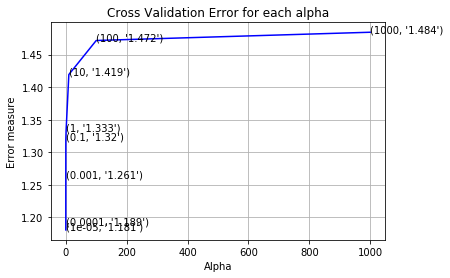

In [131]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_LR_re , c = 'blue')
for i, txt in enumerate(np.round(cv_log_error_LR_re , 3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i] , cv_log_error_LR_re[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error measure")
plt.show()

In [132]:
best_alpha = np.argmin(cv_log_error_LR_re)

lr_re = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
lr_re.fit(train_x_responseEncoding , train_y)
    
ccv_lr_re = CalibratedClassifierCV(lr_re , method = "sigmoid")
ccv_lr_re.fit(train_x_responseEncoding , train_y)

predict_y = ccv_lr_re.predict_proba(train_x_responseEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train , predict_y , labels=lr_re.classes_, eps=1e-15))

predict_y = ccv_lr_re.predict_proba(test_x_responseEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test , predict_y, labels=lr_re.classes_, eps=1e-15))

predict_y = ccv_lr_re.predict_proba(cv_x_responseEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv , predict_y, labels=lr_re.classes_, eps=1e-15))

For values of best alpha =  1e-05 The train log loss is: 1.3237007107867664
For values of best alpha =  1e-05 The test log loss is: 1.3426309353571366
For values of best alpha =  1e-05 The cross validation log loss is: 1.4015658241330107


Log loss : 1.1816852298181206
Number of mis-classified points : 0.42105263157894735
-------------------- Confusion matrix --------------------


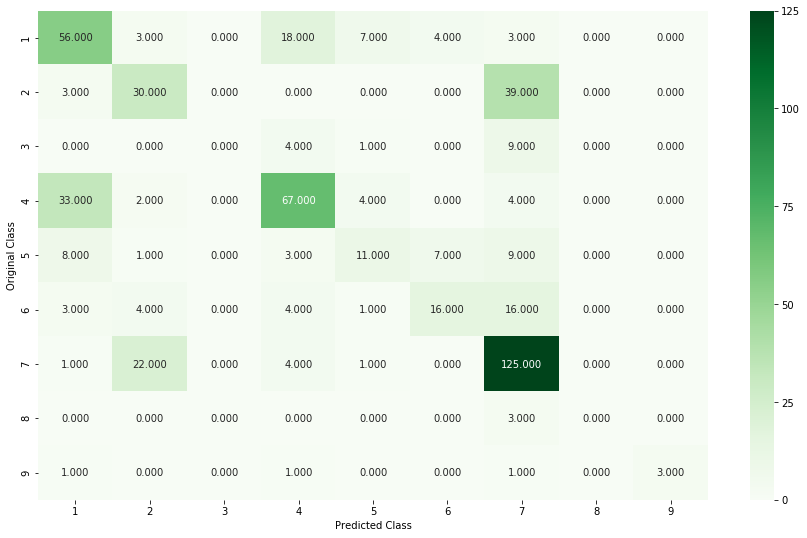

-------------------- Precision matrix (Columm Sum=1) --------------------


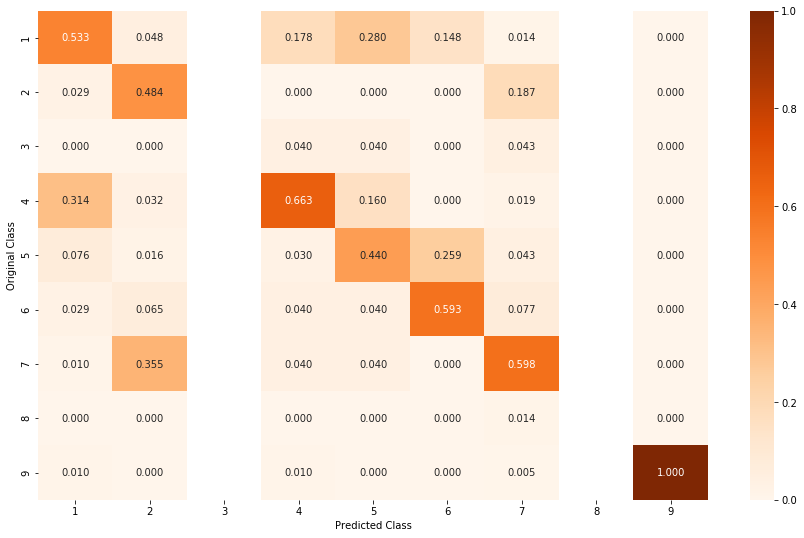

-------------------- Recall matrix (Row sum=1) --------------------


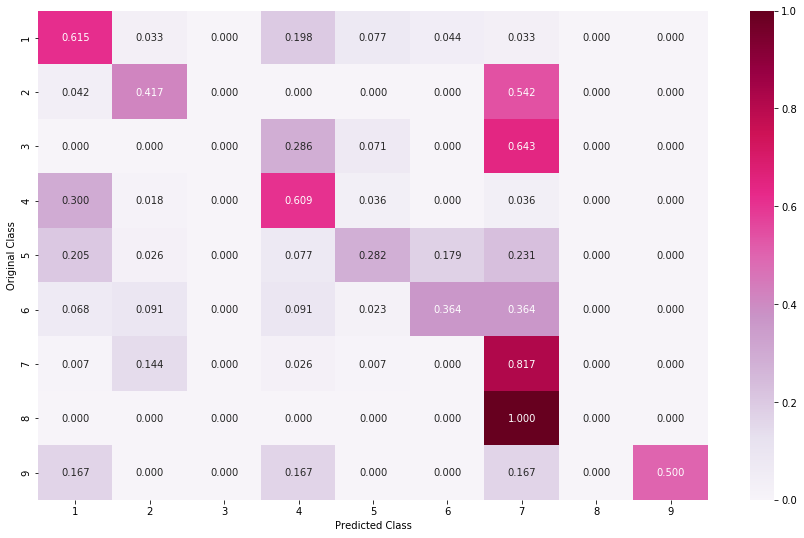

In [283]:
sgd = SGDClassifier(class_weight='balanced', alpha=0.00001 , penalty = 'l2', loss='log', random_state=30)
predict_and_plot_confusion_matrix(train_x_responseEncoding , train_y, cv_x_responseEncoding, cv_y , sgd)

### Interpretability with response-encoding

In [134]:
test_point_index = 58
no_feature = 500

#predicted_cls = np.reshape(ccv_lr_re.predict(test_x_responseEncoding[test_point_index].reshape(1 , -1)))
predicted_cls = ccv_lr_re.predict(test_x_responseEncoding[test_point_index].reshape(1 , -1))

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_lr_re.predict_proba(test_x_responseEncoding[test_point_index].reshape(1 , -1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-lr_re.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)

get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[9.820e-02 2.500e-03 3.250e-02 8.192e-01 2.680e-02 1.350e-02 4.700e-03
  2.100e-03 6.000e-04]]
Actual Class : 4
--------------------------------------------------
Out of the top  500  features  0 are present in query point


### Without class balancing

### one-hot-encoder

In [135]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_LR = []

for i in alpha:
    print("for alpha =", i)
    lr = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    lr.fit(train_x_onehotEncoding , train_y)
    
    ccv_lr = CalibratedClassifierCV(lr , method = "sigmoid")
    ccv_lr.fit(train_x_onehotEncoding , train_y)
    
    ccv_lr_predict = ccv_lr.predict_proba(cv_x_onehotEncoding)
    
    cv_log_error_LR.append(log_loss(cv_y, ccv_lr_predict , labels = lr.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, ccv_lr_predict)) 

for alpha = 1e-06
Log Loss : 1.5255157985992749
for alpha = 1e-05
Log Loss : 1.3707347505012626
for alpha = 0.0001
Log Loss : 1.1423614886463767
for alpha = 0.001
Log Loss : 1.1665044958144424
for alpha = 0.01
Log Loss : 1.3097164652977553
for alpha = 0.1
Log Loss : 1.5919266671654573
for alpha = 1
Log Loss : 1.6950605286430522
for alpha = 10
Log Loss : 1.7093167723485692
for alpha = 100
Log Loss : 1.7108895003758193


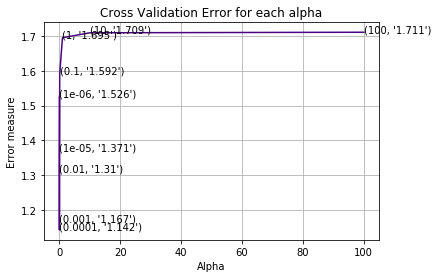

In [136]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_LR , c = 'indigo')
for i, txt in enumerate(np.round(cv_log_error_LR , 3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i] , cv_log_error_LR[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error measure")
plt.show()

In [286]:
best_alpha = np.argmin(cv_log_error_LR)

lr = SGDClassifier(alpha = alpha[best_alpha] , penalty='l2', loss='log', random_state = 30)
lr.fit(train_x_onehotEncoding , train_y)
    
ccv_lr = CalibratedClassifierCV(lr , method = "sigmoid")
ccv_lr.fit(train_x_onehotEncoding , train_y)

predict_y = ccv_lr.predict_proba(train_x_onehotEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train , predict_y , labels=lr.classes_, eps=1e-15))

predict_y = ccv_lr.predict_proba(test_x_onehotEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test , predict_y, labels=lr.classes_, eps=1e-15))

predict_y = ccv_lr.predict_proba(cv_x_onehotEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv , predict_y, labels=lr.classes_, eps=1e-15))

For values of best alpha =  0.01 The train log loss is: 0.9918122613071507
For values of best alpha =  0.01 The test log loss is: 1.1696813972396074
For values of best alpha =  0.01 The cross validation log loss is: 1.3098413717607214


Log loss : 1.3098413717607214
Number of mis-classified points : 0.41541353383458646
-------------------- Confusion matrix --------------------


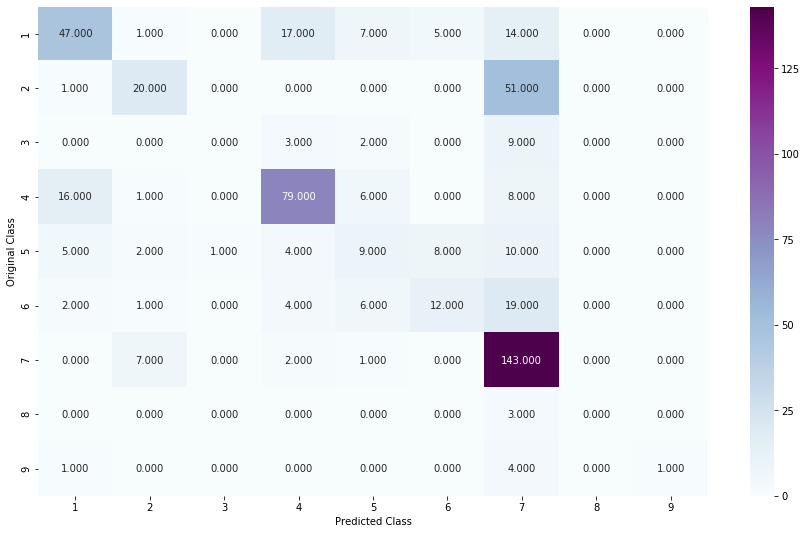

-------------------- Precision matrix (Columm Sum=1) --------------------


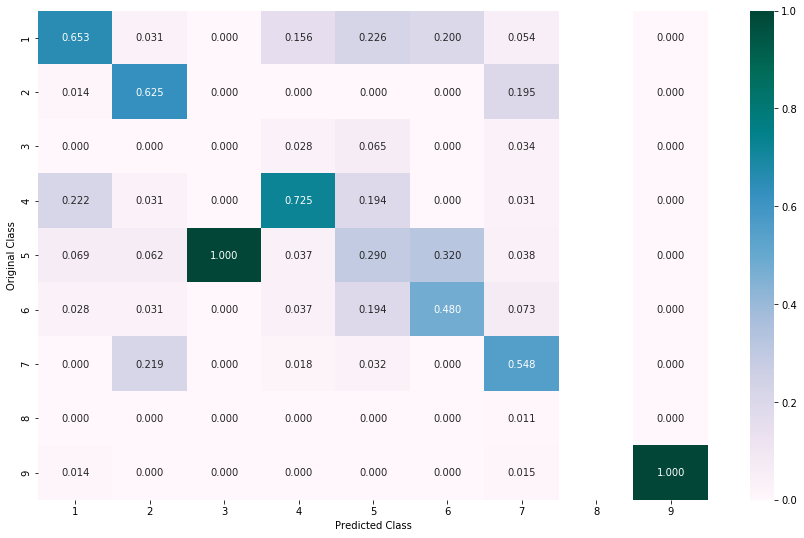

-------------------- Recall matrix (Row sum=1) --------------------


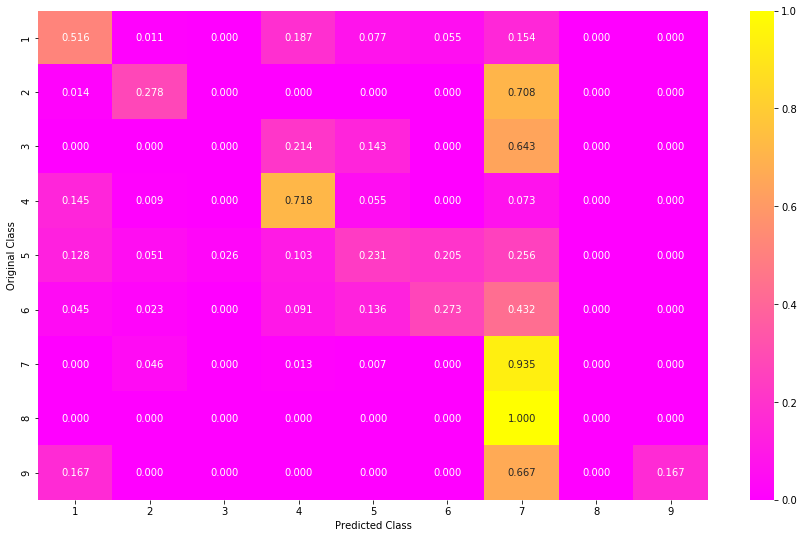

In [287]:
sgd = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=30)
predict_and_plot_confusion_matrix(train_x_onehotEncoding , train_y, cv_x_onehotEncoding, cv_y , sgd)

### Interpretability

In [139]:
test_point_index = 78
no_feature = 500

predicted_cls = ccv_lr.predict(test_x_onehotEncoding[test_point_index])

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_lr.predict_proba(test_x_onehotEncoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-lr.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)

get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[9.95e-01 1.00e-03 8.00e-04 3.00e-04 1.40e-03 7.00e-04 5.00e-04 1.00e-04
  1.00e-04]]
Actual Class : 1
--------------------------------------------------
233 Text feature [serves] present in test data point [True]
417 Text feature [correct] present in test data point [True]
429 Text feature [transcription] present in test data point [True]
439 Text feature [lethal] present in test data point [True]
446 Text feature [screened] present in test data point [True]
482 Text feature [aggregation] present in test data point [True]
Out of the top  500  features  6 are present in query point


### Response-encoding

In [411]:
alpha = [0.00001 , 0.0001 , 0.001 , 0.1 , 1 , 10 , 100 , 1000]
cv_log_error_LR_re = []

for i in alpha:
    print("for alpha =", i)
    lr_re = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    lr_re.fit(train_x_responseEncoding , train_y)
    
    ccv_lr_re = CalibratedClassifierCV(lr_re , method = "sigmoid")
    ccv_lr_re.fit(train_x_responseEncoding , train_y)
    
    ccv_lr_predict_lr = ccv_lr_re.predict_proba(cv_x_responseEncoding)
    
    cv_log_error_LR_re.append(log_loss(cv_y, ccv_lr_predict_lr , labels = lr_re.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, ccv_lr_predict_lr)) 

for alpha = 1e-05
Log Loss : 1.1178431373766256
for alpha = 0.0001
Log Loss : 1.1437144577211469
for alpha = 0.001
Log Loss : 1.22113980532543
for alpha = 0.1
Log Loss : 1.308977879672518
for alpha = 1
Log Loss : 1.309878270337641
for alpha = 10
Log Loss : 1.3797646270847672
for alpha = 100
Log Loss : 1.4159464191612443
for alpha = 1000
Log Loss : 1.427334033405493


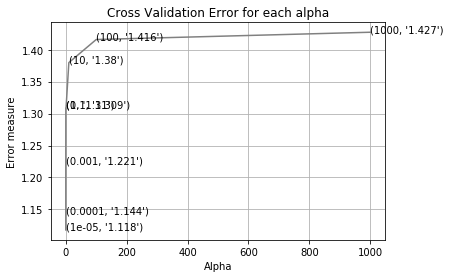

In [412]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_LR_re , c = 'gray')
for i, txt in enumerate(np.round(cv_log_error_LR_re , 3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i] , cv_log_error_LR_re[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error measure")
plt.show()

In [413]:
best_alpha = np.argmin(cv_log_error_LR_re)

lr_re = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
lr_re.fit(train_x_responseEncoding , train_y)
    
ccv_lr_re = CalibratedClassifierCV(lr_re , method = "sigmoid")
ccv_lr_re.fit(train_x_responseEncoding , train_y)

predict_y = ccv_lr_re.predict_proba(train_x_responseEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train , predict_y , labels=lr_re.classes_, eps=1e-15))

predict_y = ccv_lr_re.predict_proba(test_x_responseEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test , predict_y, labels=lr_re.classes_, eps=1e-15))

predict_y = ccv_lr_re.predict_proba(cv_x_responseEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv , predict_y, labels=lr_re.classes_, eps=1e-15))

For values of best alpha =  1e-05 The train log loss is: 1.3029464857941273
For values of best alpha =  1e-05 The test log loss is: 1.3184665046616277
For values of best alpha =  1e-05 The cross validation log loss is: 1.3664444804890672


Log loss : 1.120566171943496
Number of mis-classified points : 0.37218045112781956
-------------------- Confusion matrix --------------------


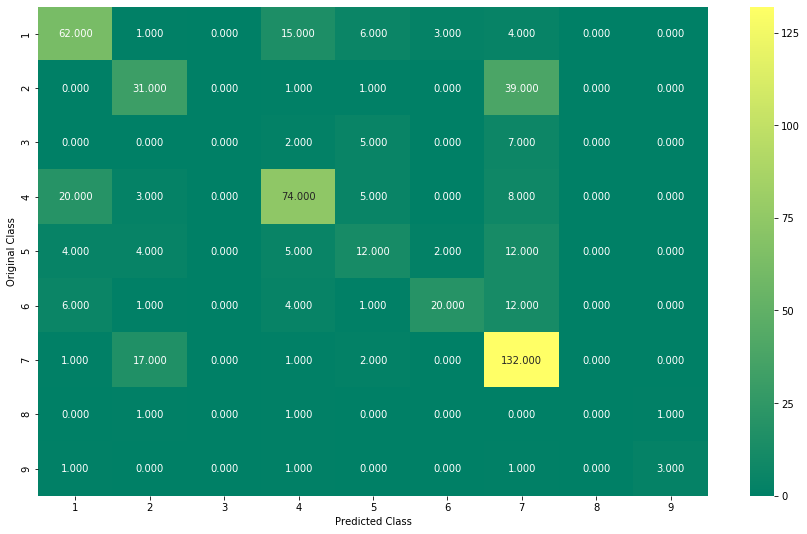

-------------------- Precision matrix (Columm Sum=1) --------------------


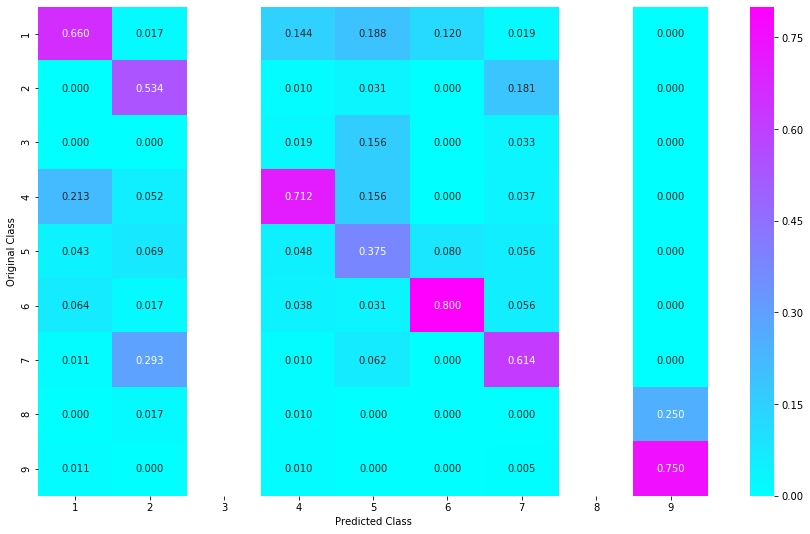

-------------------- Recall matrix (Row sum=1) --------------------


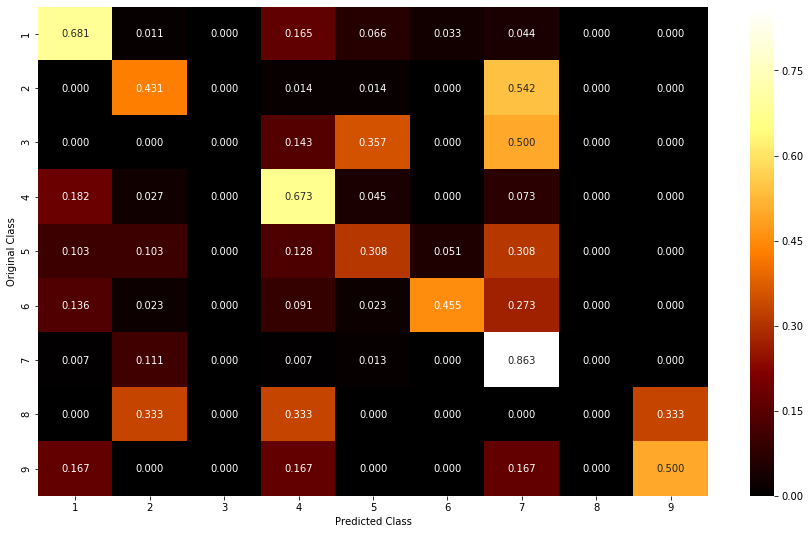

In [414]:
sgd = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=30)
predict_and_plot_confusion_matrix(train_x_responseEncoding , train_y, cv_x_responseEncoding, cv_y , sgd)

### Interpretabiliy of Logistic regression with response-encoding

In [415]:
test_point_index = 1
no_feature = 500

predicted_cls = ccv_lr_re.predict(test_x_responseEncoding[test_point_index].reshape(1,-1))

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_lr_re.predict_proba(test_x_responseEncoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-lr_re.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)

get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0065 0.0866 0.0326 0.0073 0.0117 0.0091 0.8428 0.0024 0.001 ]]
Actual Class : 7
--------------------------------------------------
Out of the top  500  features  0 are present in query point


# KNN

### One-hot-encoder

In [416]:
neighbors = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_knn = []

for i in neighbors:
    print("Neighbor =", i)
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(train_x_onehotEncoding, train_y)
    
    ccv_knn = CalibratedClassifierCV(knn , method="sigmoid")
    ccv_knn.fit(train_x_onehotEncoding, train_y)
    
    predict_knn = ccv_knn.predict_proba(cv_x_onehotEncoding)
    
    cv_log_error_knn.append(log_loss(cv_y , predict_knn , labels = knn.classes_ , eps=1e-15))
    print("Log Loss :",log_loss(cv_y, predict_knn))

Neighbor = 5
Log Loss : 1.1335970420794634
Neighbor = 11
Log Loss : 1.1616427660037132
Neighbor = 15
Log Loss : 1.1960988693650878
Neighbor = 21
Log Loss : 1.2386459832835142
Neighbor = 31
Log Loss : 1.2713170773128901
Neighbor = 41
Log Loss : 1.3052771530767258
Neighbor = 51
Log Loss : 1.3322645477826018
Neighbor = 99
Log Loss : 1.3612447432460977


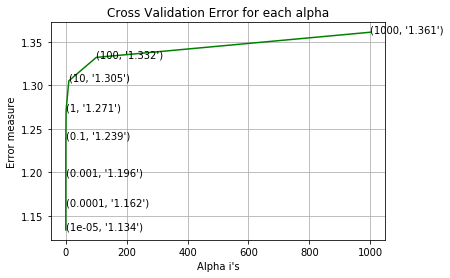

In [417]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_knn , c = 'g')
for i, txt in enumerate(np.round(cv_log_error_knn,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i] , cv_log_error_knn[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [418]:
best_neighbor = np.argmin(cv_log_error_knn)

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(train_x_onehotEncoding , train_y)

ccv_knn = CalibratedClassifierCV(knn , method="sigmoid")
ccv_knn.fit(train_x_onehotEncoding , train_y)

predict_knn = ccv_knn.predict_proba(train_x_onehotEncoding)
print('Best value for neighbor  = ', 5, "The train log loss is:",log_loss(y_train, predict_knn, labels=knn.classes_, eps=1e-15))

predict_knn = ccv_knn.predict_proba(cv_x_onehotEncoding)
print('Best value for neighbor = ', 5, "The cross validation log loss is:",log_loss(y_cv, predict_knn, labels=knn.classes_, eps=1e-15))

predict_knn = ccv_knn.predict_proba(test_x_onehotEncoding)
print('Best value for neighbor = ', 5 , "The test log loss is:",log_loss(y_test, predict_knn, labels=knn.classes_, eps=1e-15))

Best value for neighbor  =  5 The train log loss is: 0.8907294571295445
Best value for neighbor =  5 The cross validation log loss is: 1.1335970420794634
Best value for neighbor =  5 The test log loss is: 1.1386671090861078


Log loss : 1.1335970420794634
Number of mis-classified points : 0.39285714285714285
-------------------- Confusion matrix --------------------


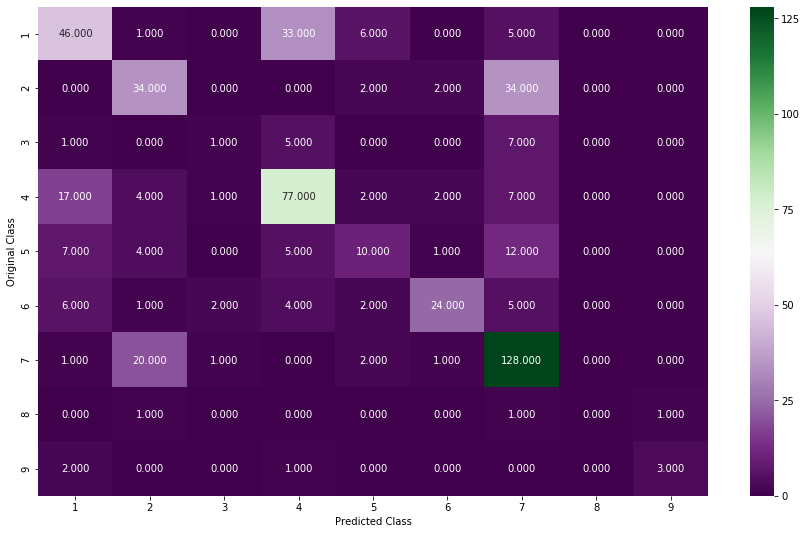

-------------------- Precision matrix (Columm Sum=1) --------------------


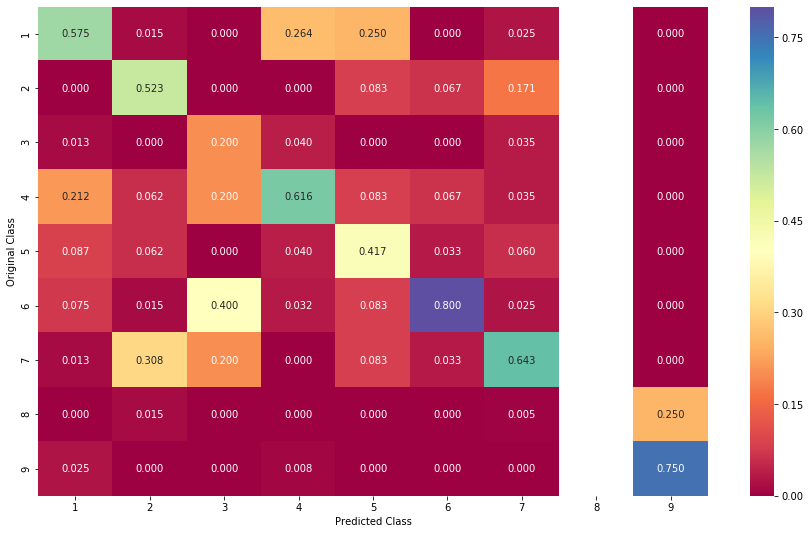

-------------------- Recall matrix (Row sum=1) --------------------


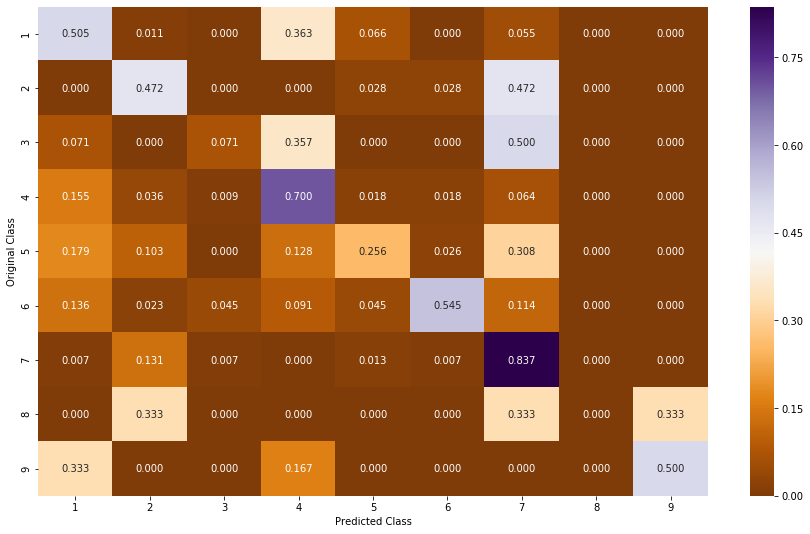

In [458]:
knn = KNeighborsClassifier(n_neighbors = 5)
predict_and_plot_confusion_matrix(train_x_onehotEncoding , train_y , cv_x_onehotEncoding , cv_y , knn)

### Interpretability of KNN with one-hot-encoder

In [420]:
test_point_index = 1
predicted_cls = ccv_knn.predict(test_x_onehotEncoding[0].reshape(1,-1))

print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])

neighbors = knn.kneighbors(test_x_onehotEncoding[test_point_index].reshape(1, -1), 5)

print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

print("Predicted Class Probabilities:", np.round(ccv_knn.predict_proba(test_x_onehotEncoding[test_point_index]),4))


Predicted Class : 4
Actual Class : 7
The  1e-05  nearest neighbours of the test points belongs to classes [4 4 4 7 7]
Fequency of nearest points : Counter({4: 3, 7: 2})
Predicted Class Probabilities: [[0.0504 0.1029 0.0174 0.4287 0.0368 0.0273 0.3258 0.0046 0.0059]]


In [421]:
test_point_index = 511
predicted_cls = ccv_knn.predict(test_x_onehotEncoding[test_point_index])

print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])

neighbors = knn.kneighbors(test_x_onehotEncoding[test_point_index].reshape(1, -1), 10)

print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

print("Predicted Class Probabilities:", np.round(ccv_knn.predict_proba(test_x_onehotEncoding[test_point_index]),4))


Predicted Class : 4
Actual Class : 4
The  1e-05  nearest neighbours of the test points belongs to classes [3 4 4 4 4 4 4 4 4 1]
Fequency of nearest points : Counter({4: 8, 3: 1, 1: 1})
Predicted Class Probabilities: [[0.0574 0.0566 0.0451 0.7227 0.0321 0.024  0.053  0.004  0.0052]]


### Response-Encoding

In [422]:
neighbors = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_knn_re = []

for i in neighbors:
    print("Neighbor =", i)
    knn_re = KNeighborsClassifier(n_neighbors = i)
    knn_re.fit(train_x_responseEncoding, train_y)
    
    ccv_knn_re = CalibratedClassifierCV(knn_re , method="sigmoid")
    ccv_knn_re.fit(train_x_responseEncoding, train_y)
    
    predict_knn_re = ccv_knn_re.predict_proba(cv_x_responseEncoding)
    
    cv_log_error_knn_re.append(log_loss(cv_y , predict_knn_re , labels = knn_re.classes_ , eps=1e-15))
    print("Log Loss :",log_loss(cv_y, predict_knn_re))

Neighbor = 5
Log Loss : 1.1102903979853265
Neighbor = 11
Log Loss : 1.1007113208246886
Neighbor = 15
Log Loss : 1.1086024667755492
Neighbor = 21
Log Loss : 1.116535283020045
Neighbor = 31
Log Loss : 1.128478495177705
Neighbor = 41
Log Loss : 1.1140918982679842
Neighbor = 51
Log Loss : 1.113563100534347
Neighbor = 99
Log Loss : 1.1158604685618656


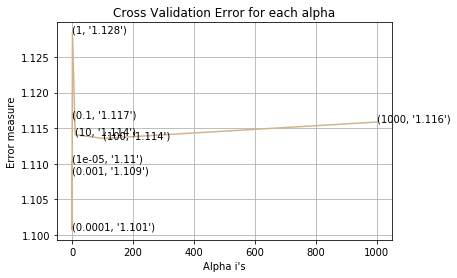

In [423]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_knn_re,c='tan')
for i, txt in enumerate(np.round(cv_log_error_knn_re,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_knn_re[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [424]:
best_alpha = np.argmin(cv_log_error_knn_re)

knn_re = KNeighborsClassifier(n_neighbors = 11)
knn_re.fit(train_x_responseEncoding, train_y)

ccv_knn_re = CalibratedClassifierCV(knn_re, method="sigmoid")
ccv_knn_re.fit(train_x_responseEncoding, train_y)

predict_y = ccv_knn_re.predict_proba(train_x_responseEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=knn_re.classes_, eps=1e-15))
predict_y = ccv_knn_re.predict_proba(cv_x_responseEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=knn_re.classes_, eps=1e-15))
predict_y = ccv_knn_re.predict_proba(test_x_responseEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=knn_re.classes_, eps=1e-15))


For values of best alpha =  0.0001 The train log loss is: 0.7440651869554531
For values of best alpha =  0.0001 The cross validation log loss is: 1.1007113208246886
For values of best alpha =  0.0001 The test log loss is: 1.1068539324358921


Log loss : 1.1007113208246886
Number of mis-classified points : 0.38345864661654133
-------------------- Confusion matrix --------------------


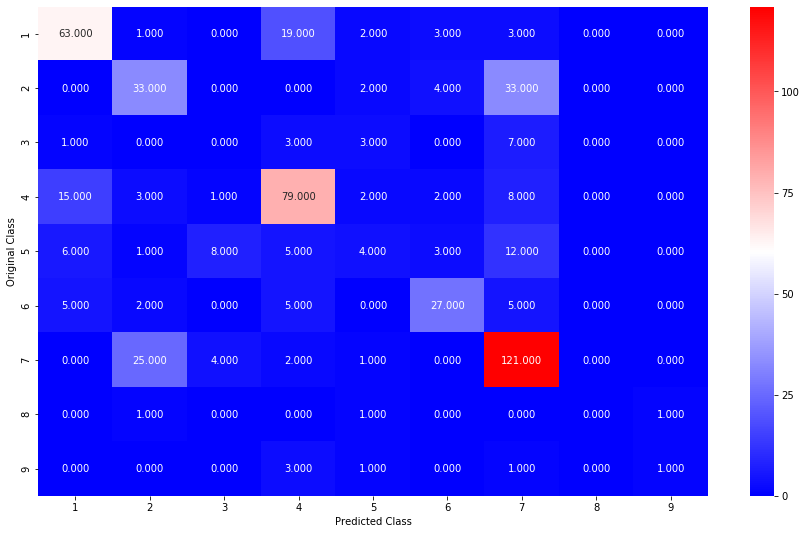

-------------------- Precision matrix (Columm Sum=1) --------------------


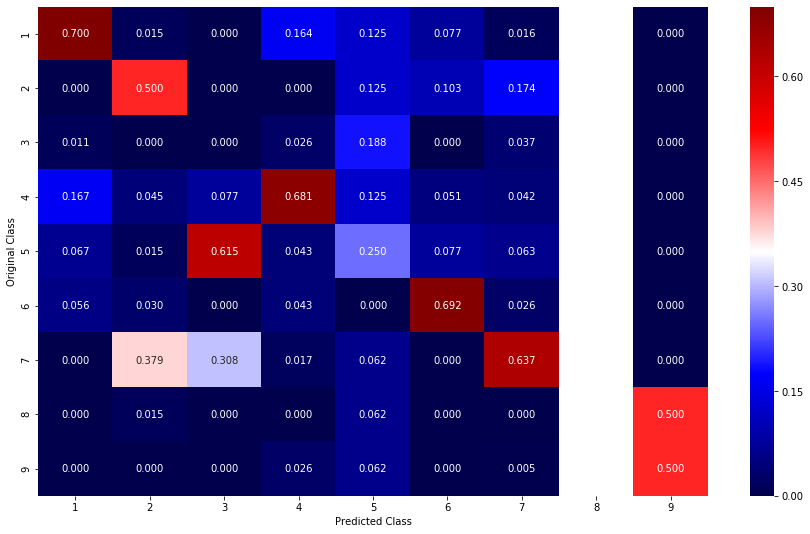

-------------------- Recall matrix (Row sum=1) --------------------


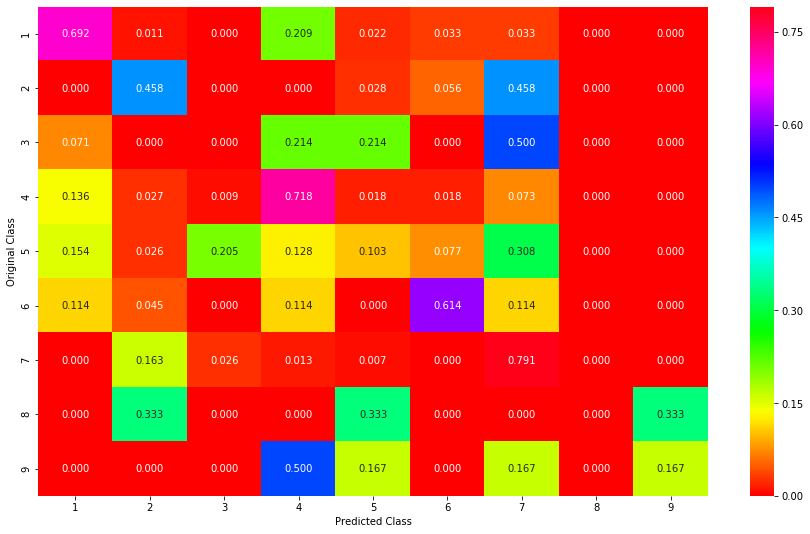

In [460]:
knn = KNeighborsClassifier(n_neighbors = 11)
predict_and_plot_confusion_matrix(train_x_responseEncoding, train_y, cv_x_responseEncoding, cv_y, knn)

### Interpretability with Response-encoding

In [426]:
test_point_index = 1
predicted_cls = ccv_knn_re.predict(test_x_responseEncoding[test_point_index].reshape(1,-1))

print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])

neighbors = knn_re.kneighbors(test_x_responseEncoding[test_point_index].reshape(1, -1), 11)

print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points ",Counter(train_y[neighbors[1][0]]))

print("Predicted Class Probabilities:", np.round(ccv_knn_re.predict_proba(test_x_responseEncoding[test_point_index].reshape(1 , -1)),4))

Predicted Class : 7
Actual Class : 7
The  0.0001  nearest neighbours of the test points belongs to classes [4 4 4 7 7 7 7 7 7 7 4]
Fequency of nearest points  Counter({7: 7, 4: 4})
Predicted Class Probabilities: [[0.0326 0.0343 0.0115 0.1678 0.0299 0.0257 0.6879 0.004  0.0063]]


In [427]:
test_point_index = 51
predicted_cls = ccv_knn_re.predict(test_x_responseEncoding[test_point_index].reshape(1,-1))

print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])

neighbors = knn_re.kneighbors(test_x_responseEncoding[test_point_index].reshape(1, -1), 11)

print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

print("Predicted Class Probabilities:", np.round(ccv_knn_re.predict_proba(test_x_responseEncoding[test_point_index].reshape(1 , -1)),4))

Predicted Class : 6
Actual Class : 7
The  0.0001  nearest neighbours of the test points belongs to classes [7 7 7 7 6 6 6 6 6 6 6]
Fequency of nearest points : Counter({6: 7, 7: 4})
Predicted Class Probabilities: [[0.0325 0.0455 0.0117 0.0293 0.03   0.6853 0.1553 0.0041 0.0063]]


In [428]:
test_point_index = 133
predicted_cls = ccv_knn_re.predict(test_x_responseEncoding[test_point_index].reshape(1,-1))

print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])

neighbors = knn_re.kneighbors(test_x_responseEncoding[test_point_index].reshape(1, -1), 11)

print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

print("Predicted Class Probabilities:", np.round(ccv_knn_re.predict_proba(test_x_responseEncoding[test_point_index].reshape(1 , -1)),4))

Predicted Class : 2
Actual Class : 2
The  0.0001  nearest neighbours of the test points belongs to classes [7 2 2 7 2 7 2 2 2 7 7]
Fequency of nearest points : Counter({2: 6, 7: 5})
Predicted Class Probabilities: [[0.0289 0.6224 0.0101 0.0257 0.0264 0.0226 0.2546 0.0036 0.0056]]


# NAIVE BAYES

### One-Hot-Encoding

In [429]:
alpha = [0.00001 , 0.0001 , 0.001 , 0.1 , 1 , 10 , 100 , 1000]
cv_log_error_NB = []
for i in alpha:
    print("alpha: ",i)
    mnb = MultinomialNB(alpha = i)
    mnb.fit(train_x_onehotEncoding , train_y)
    
    ccv_mnb = CalibratedClassifierCV(mnb , method = 'sigmoid')
    ccv_mnb.fit(train_x_onehotEncoding , train_y)
    
    predict_ccv_onehotencoding = ccv_mnb.predict_proba(cv_x_onehotEncoding)
    
    cv_log_error_NB.append(log_loss(cv_y , predict_ccv_onehotencoding , labels = mnb.classes_ , eps = 1e-15))
    
    print("Log Loss :",log_loss(cv_y, predict_ccv_onehotencoding)) 

alpha:  1e-05
Log Loss : 1.2927041578326062
alpha:  0.0001
Log Loss : 1.2831396735628993
alpha:  0.001
Log Loss : 1.2718804022283532
alpha:  0.1
Log Loss : 1.2320500925388316
alpha:  1
Log Loss : 1.2575377802042778
alpha:  10
Log Loss : 1.3294984466998607
alpha:  100
Log Loss : 1.3549433178865768
alpha:  1000
Log Loss : 1.3323007948946388


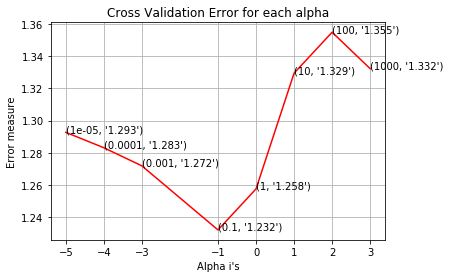

In [430]:
#plot on grpah
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_NB , c='red')
for i, txt in enumerate(np.round(cv_log_error_NB,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_NB[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [431]:
best_alpha = np.argmin(cv_log_error_NB)

mnb = MultinomialNB(alpha=alpha[best_alpha])
mnb.fit(train_x_onehotEncoding, train_y)
ccv_mnb = CalibratedClassifierCV(mnb , method="sigmoid")
ccv_mnb.fit(train_x_onehotEncoding, train_y)


predict_ccv_onehotencoding = ccv_mnb.predict_proba(train_x_onehotEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_ccv_onehotencoding, labels=mnb.classes_, eps=1e-15))

predict_ccv_onehotencoding = ccv_mnb.predict_proba(cv_x_onehotEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_ccv_onehotencoding, labels=mnb.classes_, eps=1e-15))

predict_ccv_onehotencoding = ccv_mnb.predict_proba(test_x_onehotEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_ccv_onehotencoding, labels=mnb.classes_, eps=1e-15))

For values of best alpha =  0.1 The train log loss is: 0.6744661740020055
For values of best alpha =  0.1 The cross validation log loss is: 1.2320500925388316
For values of best alpha =  0.1 The test log loss is: 1.2617254590825502


In [432]:
#test with best alpha value with TESTING data
mnb = MultinomialNB(alpha=alpha[best_alpha])
mnb.fit(train_x_onehotEncoding, train_y)

ccv_mnb = CalibratedClassifierCV(mnb , method="sigmoid")
ccv_mnb.fit(train_x_onehotEncoding, train_y)

ccv_probs = ccv_mnb.predict_proba(cv_x_onehotEncoding)

# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, ccv_probs))


Log Loss : 1.2320500925388316


Log loss : 1.2718804022283532
Number of mis-classified points : 0.4116541353383459
-------------------- Confusion matrix --------------------


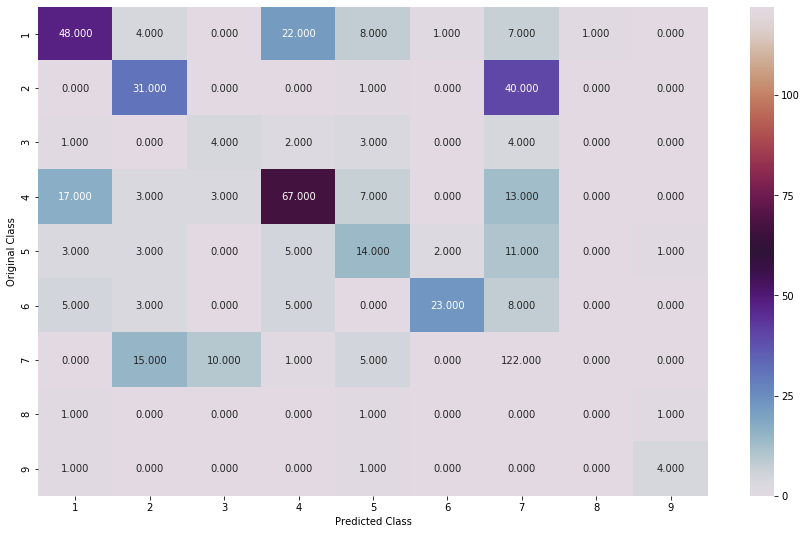

-------------------- Precision matrix (Columm Sum=1) --------------------


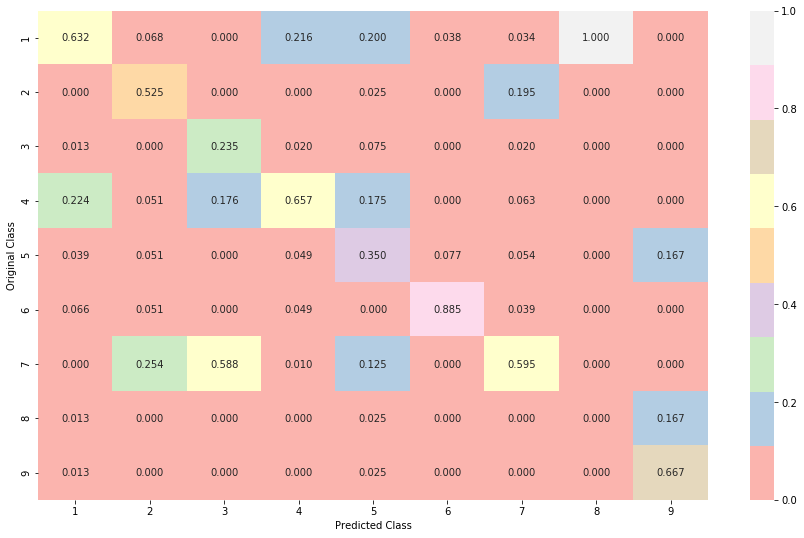

-------------------- Recall matrix (Row sum=1) --------------------


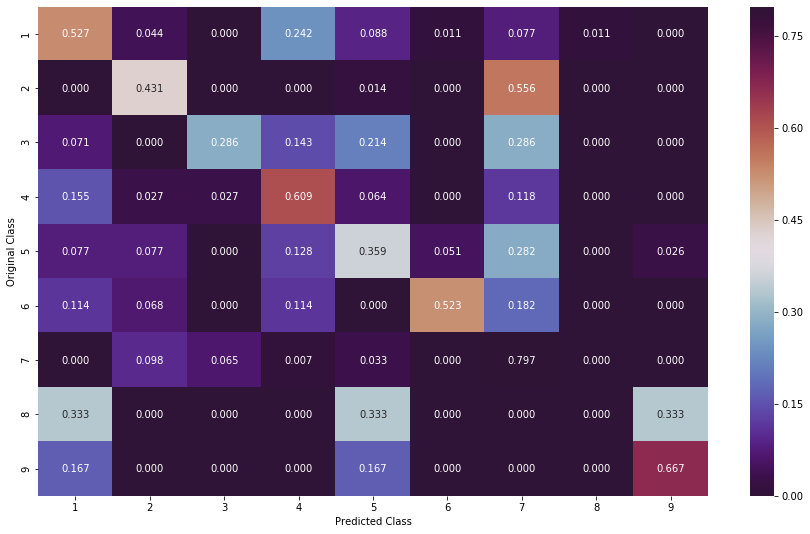

In [464]:
mnb = MultinomialNB(alpha=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_onehotEncoding , train_y, cv_x_onehotEncoding, cv_y , mnb)

### Interpretability of Naive Bayes

In [434]:
test_point_index = 1
no_feature = 100

predicted_cls = ccv_mnb.predict(test_x_onehotEncoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_mnb.predict_proba(test_x_onehotEncoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-mnb.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0644 0.0591 0.0148 0.4508 0.029  0.0354 0.3394 0.0037 0.0034]]
Actual Class : 7
--------------------------------------------------
18 Text feature [activity] present in test data point [True]
19 Text feature [protein] present in test data point [True]
25 Text feature [proteins] present in test data point [True]
26 Text feature [bind] present in test data point [True]
28 Text feature [bsa] present in test data point [True]
29 Text feature [effect] present in test data point [True]
30 Text feature [also] present in test data point [True]
32 Text feature [whether] present in test data point [True]
33 Text feature [shown] present in test data point [True]
35 Text feature [levels] present in test data point [True]
36 Text feature [containing] present in test data point [True]
38 Text feature [mutant] present in test data point [True]
40 Text feature [however] present in test data point [True]
41 Text feature [described] present in test 

In [435]:
test_point_index = 100
no_feature = 100
predicted_cls = ccv_mnb.predict(test_x_onehotEncoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_mnb.predict_proba(test_x_onehotEncoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-mnb.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.0951 0.0925 0.022  0.107  0.1664 0.3059 0.201  0.0053 0.0049]]
Actual Class : 6
--------------------------------------------------
73 Text feature [typically] present in test data point [True]
Out of the top  100  features  1 are present in query point


In [436]:
test_point_index = 512
no_feature = 100

predicted_cls = ccv_mnb.predict(test_x_onehotEncoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_mnb.predict_proba(test_x_onehotEncoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-mnb.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.6327 0.0673 0.0166 0.1008 0.0329 0.04   0.1017 0.0041 0.0038]]
Actual Class : 1
--------------------------------------------------
16 Text feature [type] present in test data point [True]
17 Text feature [therefore] present in test data point [True]
18 Text feature [protein] present in test data point [True]
19 Text feature [role] present in test data point [True]
20 Text feature [region] present in test data point [True]
21 Text feature [whether] present in test data point [True]
22 Text feature [control] present in test data point [True]
23 Text feature [functions] present in test data point [True]
24 Text feature [wild] present in test data point [True]
25 Text feature [functional] present in test data point [True]
26 Text feature [four] present in test data point [True]
33 Text feature [also] present in test data point [True]
36 Text feature [expression] present in test data point [True]
37 Text feature [reduced] present in tes

### Response-Encoding 

In [437]:
alpha = [0.00001 , 0.0001 , 0.001 , 0.1 , 1 , 10 , 100 , 1000]
cv_log_error_NB_re = []
for i in alpha:
    print("alpha: ",i)
    mnb_re = MultinomialNB(alpha = i)
    mnb_re.fit(train_x_responseEncoding , train_y)
    
    ccv_mnb_re = CalibratedClassifierCV(mnb_re , method = 'sigmoid')
    ccv_mnb_re.fit(train_x_responseEncoding , train_y)
    
    predict_ccv_re = ccv_mnb_re.predict_proba(cv_x_responseEncoding)
    
    cv_log_error_NB_re.append(log_loss(cv_y , predict_ccv_re , labels = mnb_re.classes_ , eps = 1e-15))
    
    print("Log Loss :",log_loss(cv_y, predict_ccv_re)) 

alpha:  1e-05
Log Loss : 1.2862344352820871
alpha:  0.0001
Log Loss : 1.2862356207823815
alpha:  0.001
Log Loss : 1.286247522329284
alpha:  0.1
Log Loss : 1.2878319448796893
alpha:  1
Log Loss : 1.3027155100072407
alpha:  10
Log Loss : 1.3190826433717888
alpha:  100
Log Loss : 1.3265589896722503
alpha:  1000
Log Loss : 1.3259504554646258


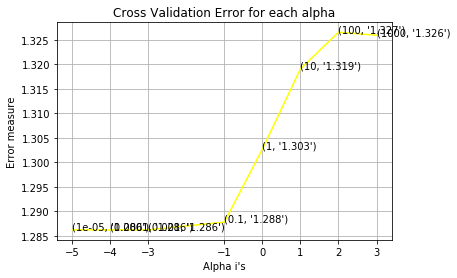

In [438]:
#plot on grpah
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_NB_re , c='yellow')
for i, txt in enumerate(np.round(cv_log_error_NB_re,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]) , cv_log_error_NB_re[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [439]:
best_alpha = np.argmin(cv_log_error_NB_re)

mnb_re = MultinomialNB(alpha=alpha[best_alpha])
mnb_re.fit(train_x_responseEncoding , train_y)

ccv_mnb_re = CalibratedClassifierCV(mnb_re , method="sigmoid")
ccv_mnb_re.fit(train_x_responseEncoding , train_y)


predict_ccv_responencoding = ccv_mnb_re.predict_proba(train_x_responseEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_ccv_responencoding, labels=mnb_re.classes_, eps=1e-15))

predict_ccv_responencoding = ccv_mnb_re.predict_proba(cv_x_responseEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_ccv_responencoding, labels=mnb_re.classes_, eps=1e-15))

predict_ccv_responencoding = ccv_mnb_re.predict_proba(test_x_responseEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_ccv_responencoding, labels=mnb_re.classes_, eps=1e-15))

For values of best alpha =  1e-05 The train log loss is: 1.2177941528777634
For values of best alpha =  1e-05 The cross validation log loss is: 1.2862344352820871
For values of best alpha =  1e-05 The test log loss is: 1.24783874152075


Log loss : 1.286247522329284
Number of mis-classified points : 0.4473684210526316
-------------------- Confusion matrix --------------------


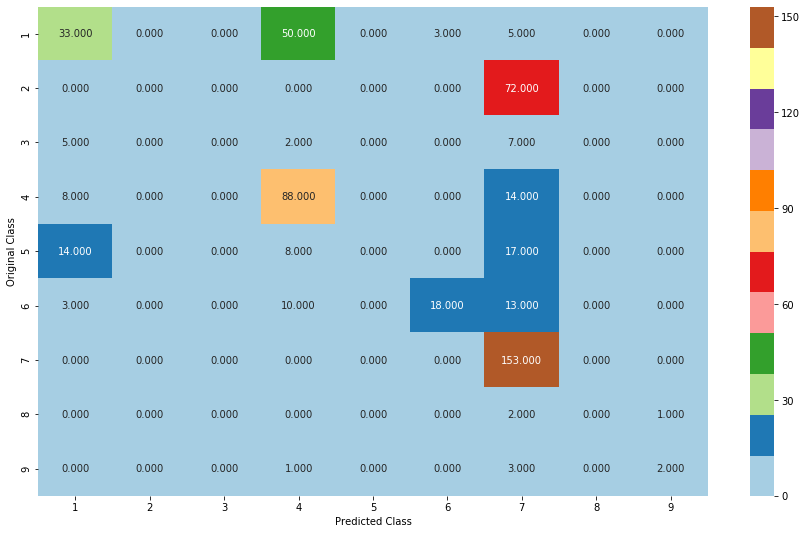

-------------------- Precision matrix (Columm Sum=1) --------------------


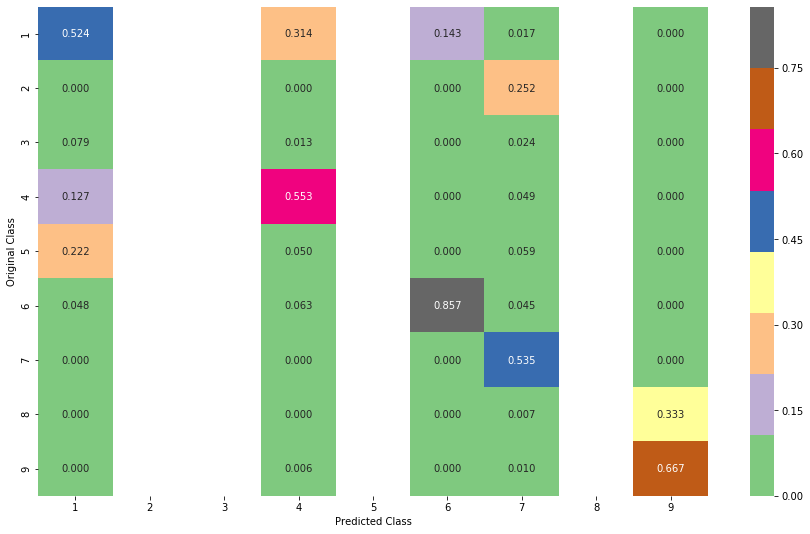

-------------------- Recall matrix (Row sum=1) --------------------


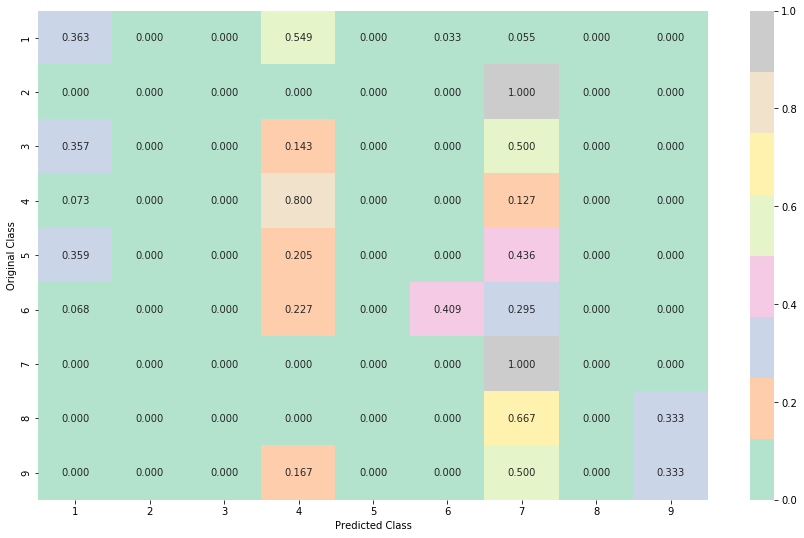

In [466]:
mnb_re = MultinomialNB(alpha=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseEncoding , train_y, cv_x_responseEncoding, cv_y , mnb_re)

### Interpretability of NB with Response-Encoding

In [441]:
test_point_index = 1
no_feature = 100

predicted_cls = ccv_mnb_re.predict(test_x_responseEncoding[test_point_index].reshape(1 , -1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_mnb_re.predict_proba(test_x_responseEncoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-mnb_re.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0048 0.3159 0.0221 0.0183 0.0151 0.0145 0.6083 0.0012 0.    ]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point


In [442]:
test_point_index = 100
no_feature = 100
predicted_cls = ccv_mnb_re.predict(test_x_responseEncoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_mnb_re.predict_proba(test_x_responseEncoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-mnb_re.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0709 0.1764 0.0383 0.1061 0.0841 0.0924 0.419  0.0092 0.0037]]
Actual Class : 6
--------------------------------------------------
Out of the top  100  features  0 are present in query point


# SVM

### One-hot-encoding

In [443]:
alpha = [10 ** x for x in range(-5, 3)]#Here alpha is C value
cv_log_error_svm = []
for i in alpha:
    print("for C =", i)
    svm = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    svm.fit(train_x_onehotEncoding , train_y)
    
    ccv_svm = CalibratedClassifierCV(svm , method="sigmoid")
    ccv_svm.fit(train_x_onehotEncoding , train_y)
    
    y_pred_svm = ccv_svm.predict_proba(cv_x_onehotEncoding)
    cv_log_error_svm.append(log_loss(cv_y, y_pred_svm, labels=svm.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, y_pred_svm)) 

for C = 1e-05
Log Loss : 1.3660799657000435
for C = 0.0001
Log Loss : 1.1883324289344472
for C = 0.001
Log Loss : 1.1400579616508115
for C = 0.01
Log Loss : 1.3276675078302167
for C = 0.1
Log Loss : 1.4687922002038916
for C = 1
Log Loss : 1.6914505918627964
for C = 10
Log Loss : 1.6914708333674962
for C = 100
Log Loss : 1.6914680636153516


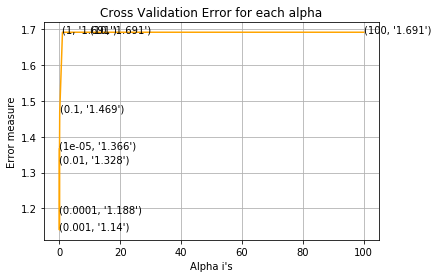

In [444]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_svm,c='orange')
for i, txt in enumerate(np.round(cv_log_error_svm,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_svm[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [445]:
best_alpha = np.argmin(cv_log_error_svm)

svm = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
svm.fit(train_x_onehotEncoding , train_y)
    
ccv_svm = CalibratedClassifierCV(svm , method="sigmoid")
ccv_svm.fit(train_x_onehotEncoding , train_y)

predict_y = ccv_svm.predict_proba(train_x_onehotEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=svm.classes_, eps=1e-15))
predict_y = ccv_svm.predict_proba(cv_x_onehotEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=svm.classes_, eps=1e-15))
predict_y = ccv_svm.predict_proba(test_x_onehotEncoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=svm.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 1.6943182485205266
For values of best alpha =  0.001 The cross validation log loss is: 1.6914708598207837
For values of best alpha =  0.001 The test log loss is: 1.732936975866818


Log loss : 1.1400579616508115
Number of mis-classified points : 0.3609022556390977
-------------------- Confusion matrix --------------------


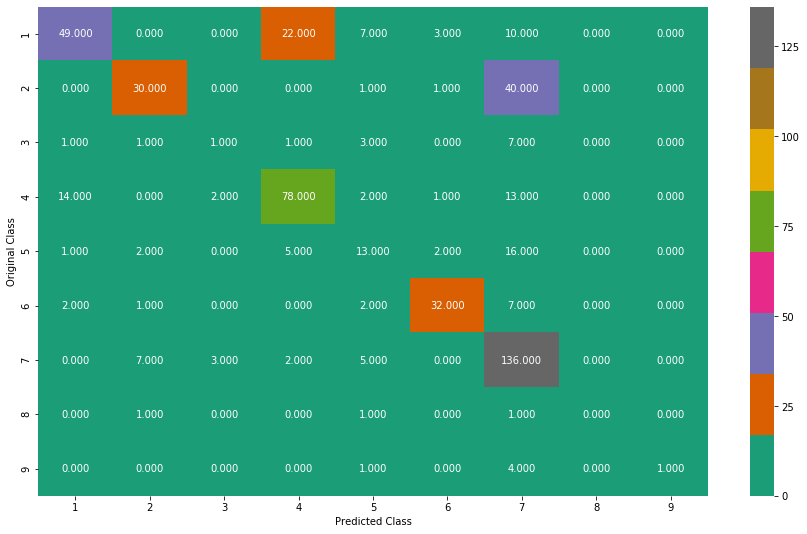

-------------------- Precision matrix (Columm Sum=1) --------------------


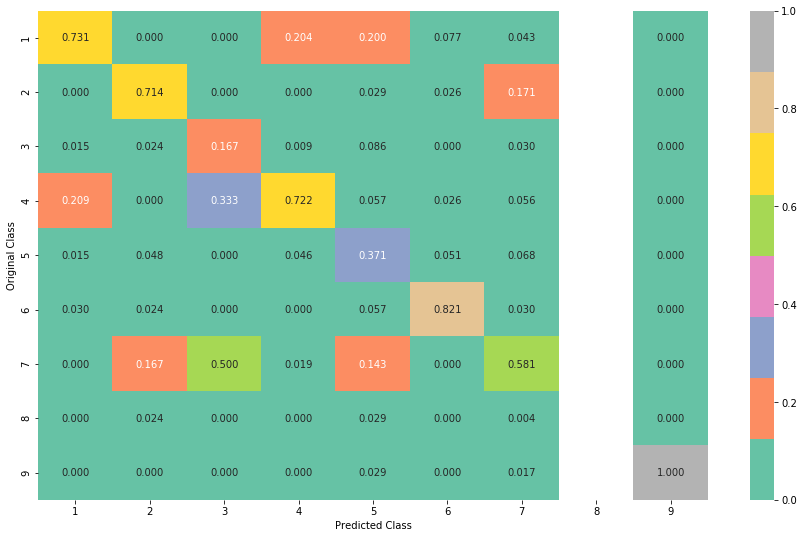

-------------------- Recall matrix (Row sum=1) --------------------


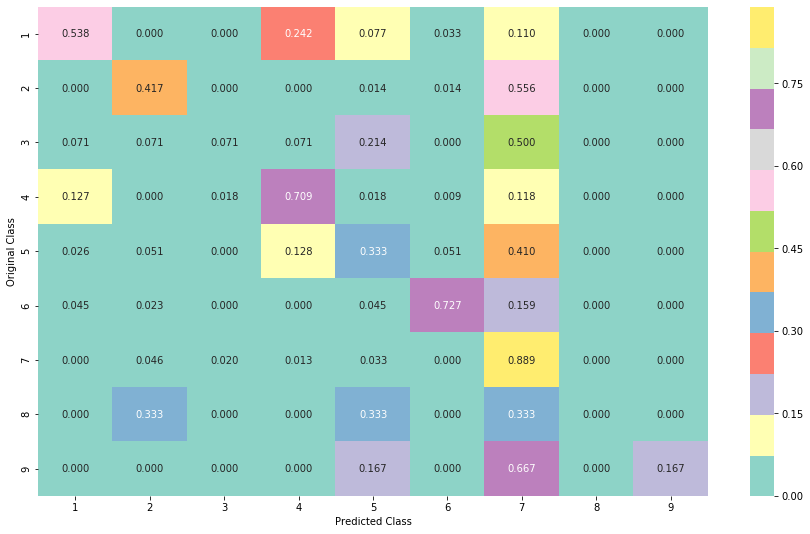

In [468]:
svm = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotEncoding, train_y,cv_x_onehotEncoding,cv_y, svm)

### Interpretability of svm with one-hot-encoding

In [447]:
test_point_index = 1
no_feature = 500

predicted_cls = ccv_svm.predict(test_x_onehotEncoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_svm.predict_proba(test_x_onehotEncoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-svm.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[2.050e-01 1.843e-01 3.460e-02 2.412e-01 7.340e-02 2.440e-02 2.311e-01
  6.000e-03 1.000e-04]]
Actual Class : 7
--------------------------------------------------
360 Text feature [devoid] present in test data point [True]
402 Text feature [mere] present in test data point [True]
439 Text feature [maintain] present in test data point [True]
483 Text feature [cetuximab] present in test data point [True]
Out of the top  500  features  4 are present in query point


In [448]:
test_point_index = 4
no_feature = 500

predicted_cls = ccv_svm.predict(test_x_onehotEncoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_svm.predict_proba(test_x_onehotEncoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-svm.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1592 0.1284 0.0256 0.1986 0.0708 0.0907 0.302  0.0076 0.0169]]
Actual Class : 7
--------------------------------------------------
Out of the top  500  features  0 are present in query point


In [449]:
test_point_index = 466
no_feature = 500

predicted_cls = ccv_svm.predict(test_x_onehotEncoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_svm.predict_proba(test_x_onehotEncoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-svm.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1789 0.1345 0.0282 0.2096 0.0851 0.0849 0.2676 0.0058 0.0055]]
Actual Class : 1
--------------------------------------------------
Out of the top  500  features  0 are present in query point


# RANDOM FOREST

### One-hot-encoder

In [179]:
alpha = [100,200,300,500,1000]
max_depth = [5, 10]
cv_log_error_rf = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        rf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        rf.fit(train_x_onehotEncoding, train_y)
        
        ccv_rf = CalibratedClassifierCV(rf, method="sigmoid")
        ccv_rf.fit(train_x_onehotEncoding, train_y)
        
        y_pred_rf = ccv_rf.predict_proba(cv_x_onehotEncoding)
        cv_log_error_rf.append(log_loss(cv_y, y_pred_rf, labels=rf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, y_pred_rf)) 

for n_estimators = 100 and max depth =  5
Log Loss : 1.4677892145591835
for n_estimators = 100 and max depth =  10
Log Loss : 1.3977331729959872
for n_estimators = 200 and max depth =  5
Log Loss : 1.459946433018646
for n_estimators = 200 and max depth =  10
Log Loss : 1.3915309057034249
for n_estimators = 300 and max depth =  5
Log Loss : 1.4517029227933436
for n_estimators = 300 and max depth =  10
Log Loss : 1.3834954294882749
for n_estimators = 500 and max depth =  5
Log Loss : 1.4455853554234408
for n_estimators = 500 and max depth =  10
Log Loss : 1.379337599027693
for n_estimators = 1000 and max depth =  5
Log Loss : 1.443534327068851
for n_estimators = 1000 and max depth =  10
Log Loss : 1.377618659602403


In [180]:
cv_log_error_rf

[1.4677892145591835,
 1.3977331729959872,
 1.459946433018646,
 1.3915309057034249,
 1.4517029227933436,
 1.3834954294882749,
 1.4455853554234408,
 1.379337599027693,
 1.443534327068851,
 1.377618659602403]

In [181]:
best_alpha = np.argmin(cv_log_error_rf)


rf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)] , random_state=42, n_jobs=-1)
rf.fit(train_x_onehotEncoding, train_y)
        
ccv_rf = CalibratedClassifierCV(rf, method="sigmoid")
ccv_rf.fit(train_x_onehotEncoding, train_y)

predict_y = ccv_rf.predict_proba(train_x_onehotEncoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=rf.classes_, eps=1e-15))

predict_y = ccv_rf.predict_proba(cv_x_onehotEncoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=rf.classes_, eps=1e-15))

predict_y = ccv_rf.predict_proba(test_x_onehotEncoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=rf.classes_, eps=1e-15))

For values of best alpha =  300 The train log loss is: 1.087590978526014
For values of best alpha =  300 The cross validation log loss is: 1.3776186596024032
For values of best alpha =  300 The test log loss is: 1.2842066616225019


Log loss : 1.464331589893113
Number of mis-classified points : 0.5169172932330827
-------------------- Confusion matrix --------------------


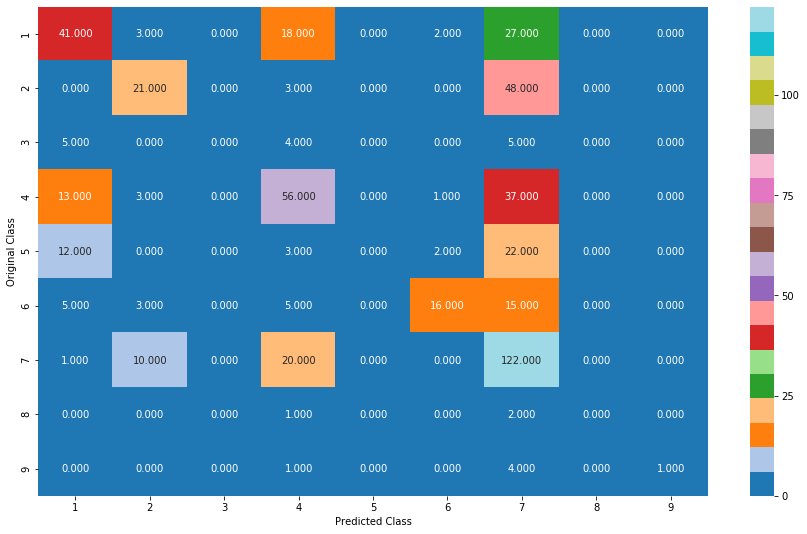

-------------------- Precision matrix (Columm Sum=1) --------------------


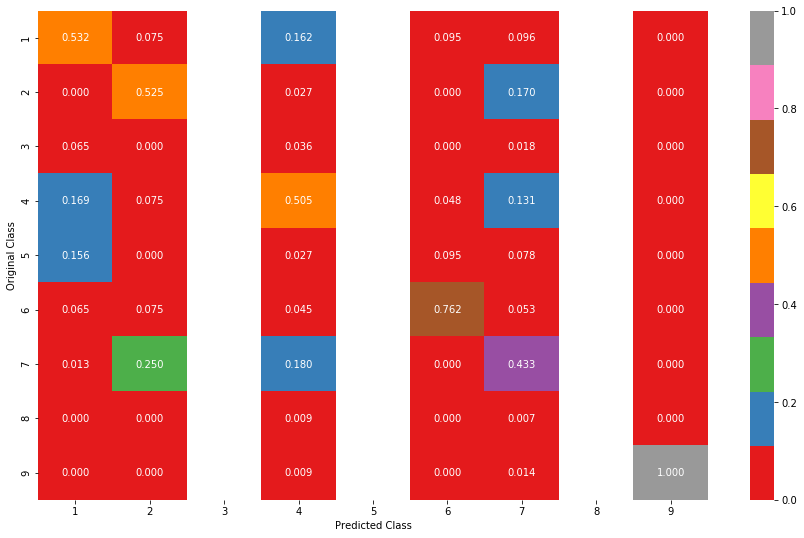

-------------------- Recall matrix (Row sum=1) --------------------


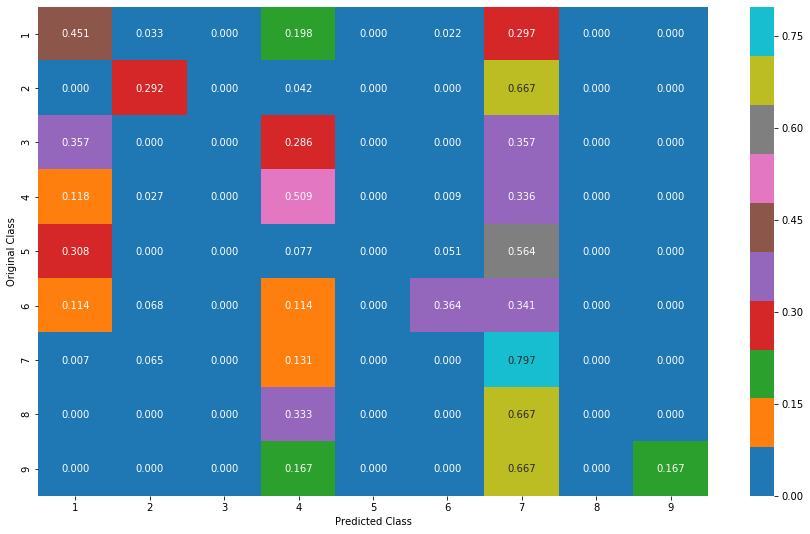

In [470]:
predict_and_plot_confusion_matrix(train_x_onehotEncoding, train_y,cv_x_onehotEncoding,cv_y, rf)

### Interpretablity of RF

In [182]:
test_point_index = 1
no_feature = 100

predicted_cls = ccv_rf.predict(test_x_onehotEncoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_rf.predict_proba(test_x_onehotEncoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-rf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1369 0.1719 0.0224 0.1376 0.0656 0.0532 0.3925 0.0098 0.0103]]
Actual Class : 7
--------------------------------------------------
35 Text feature [lung] present in test data point [True]
57 Text feature [clinical] present in test data point [True]
Out of the top  100  features  2 are present in query point


### Response-encoding

In [183]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_re = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        
        rf_re = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        rf_re.fit(train_x_responseEncoding, train_y)
        
        ccv_rf_re = CalibratedClassifierCV(rf_re, method="sigmoid")
        ccv_rf_re.fit(train_x_responseEncoding, train_y)
        
        y_pred_rf_re = ccv_rf_re.predict_proba(cv_x_responseEncoding)
        cv_log_error_re.append(log_loss(cv_y, y_pred_rf_re, labels=rf_re.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, y_pred_rf_re)) 

for n_estimators = 10 and max depth =  2
Log Loss : 2.0864799728812105
for n_estimators = 10 and max depth =  3
Log Loss : 1.7893207013923567
for n_estimators = 10 and max depth =  5
Log Loss : 1.7844454683746
for n_estimators = 10 and max depth =  10
Log Loss : 1.9354630838383144
for n_estimators = 50 and max depth =  2
Log Loss : 1.8009157335135801
for n_estimators = 50 and max depth =  3
Log Loss : 1.5910683544907702
for n_estimators = 50 and max depth =  5
Log Loss : 1.4345077641164612
for n_estimators = 50 and max depth =  10
Log Loss : 1.6856581649023628
for n_estimators = 100 and max depth =  2
Log Loss : 1.6277306529993834
for n_estimators = 100 and max depth =  3
Log Loss : 1.506896839043163
for n_estimators = 100 and max depth =  5
Log Loss : 1.377192572729206
for n_estimators = 100 and max depth =  10
Log Loss : 1.7253466094965133
for n_estimators = 200 and max depth =  2
Log Loss : 1.6526333282023393
for n_estimators = 200 and max depth =  3
Log Loss : 1.557350621310197
for

In [473]:
best_alpha = np.argmin(cv_log_error_re)

rf_re = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)] , criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
rf_re.fit(train_x_responseEncoding, train_y)
    
ccv_rf_re = CalibratedClassifierCV(rf_re, method="sigmoid")
ccv_rf_re.fit(train_x_responseEncoding, train_y)
        
y_pred_rf_re = ccv_rf_re.predict_proba(train_x_responseEncoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, y_pred_rf_re, labels=rf_re.classes_, eps=1e-15))
y_pred_rf_re = ccv_rf_re.predict_proba(cv_x_responseEncoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, y_pred_rf_re, labels=rf_re.classes_, eps=1e-15))
y_pred_rf_re = ccv_rf_re.predict_proba(test_x_responseEncoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, y_pred_rf_re, labels=rf_re.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.0716412074901688
For values of best alpha =  0.001 The cross validation log loss is: 1.354969293275707
For values of best alpha =  0.001 The test log loss is: 1.3288802508564364


Log loss : 1.3549692932757071
Number of mis-classified points : 0.4924812030075188
-------------------- Confusion matrix --------------------


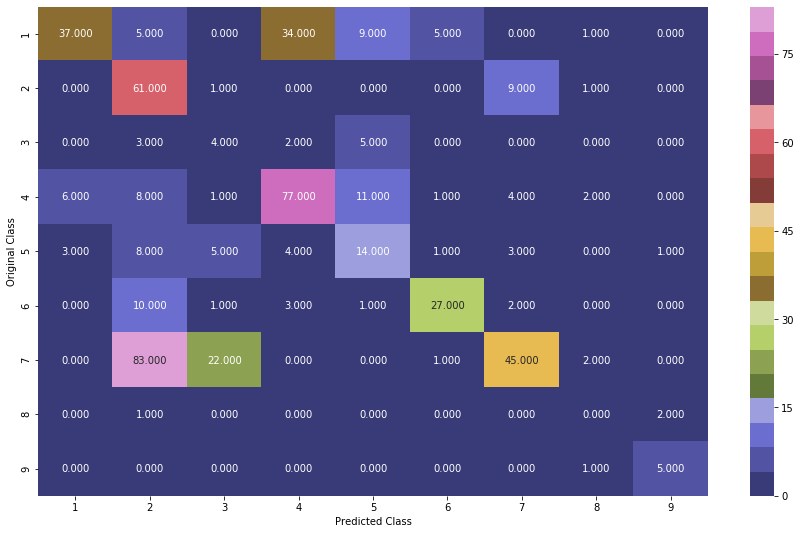

-------------------- Precision matrix (Columm Sum=1) --------------------


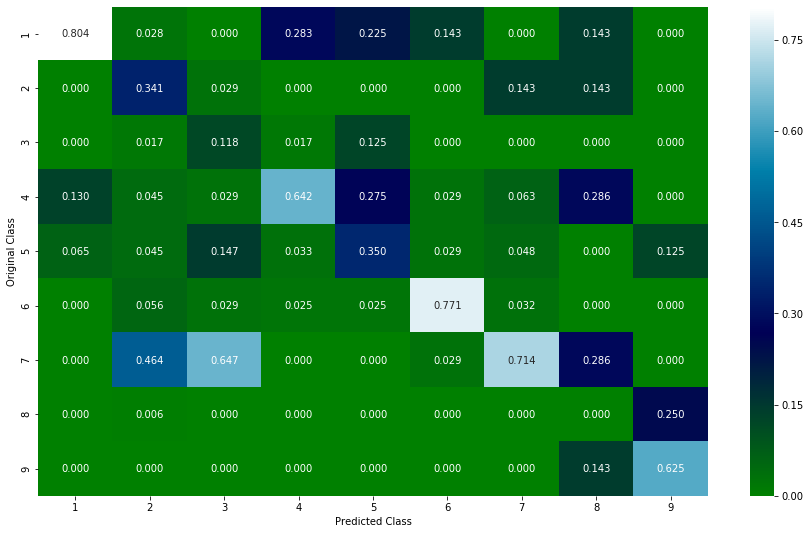

-------------------- Recall matrix (Row sum=1) --------------------


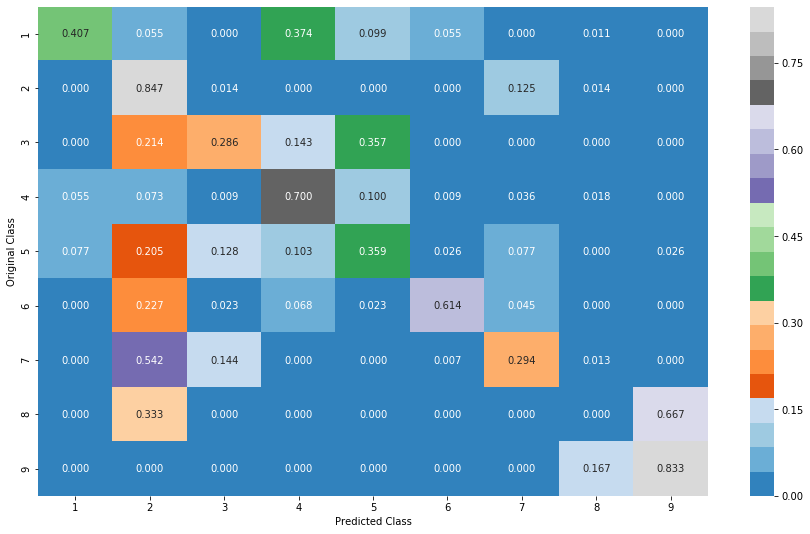

In [476]:
predict_and_plot_confusion_matrix(train_x_responseEncoding, train_y,cv_x_responseEncoding,cv_y, rf_re)

In [186]:
test_point_index = 1
no_feature = 27

predicted_cls = ccv_rf_re.predict(test_x_responseEncoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_rf_re.predict_proba(test_x_responseEncoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-rf_re.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 7
Predicted Class Probabilities: [[0.0262 0.298  0.1357 0.024  0.0317 0.0616 0.3348 0.0526 0.0355]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature


In [187]:
test_point_index = 222
no_feature = 27

predicted_cls = ccv_rf_re.predict(test_x_responseEncoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_rf_re.predict_proba(test_x_responseEncoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-rf_re.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 1
Predicted Class Probabilities: [[0.9185 0.0174 0.0036 0.0145 0.0028 0.0214 0.0038 0.0081 0.01  ]]
Actual Class : 1
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature


In [188]:
test_point_index = 434
no_feature = 500

predicted_cls = ccv_rf_re.predict(test_x_responseEncoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_rf_re.predict_proba(test_x_responseEncoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-rf_re.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 6
Predicted Class Probabilities: [[0.009  0.0069 0.0069 0.007  0.0064 0.9415 0.0024 0.0108 0.009 ]]
Actual Class : 5
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature


# ADABOOST

### one-hot-encoding

In [189]:
shallow_tree = DecisionTreeClassifier(max_depth=5)
shallow_tree.fit(train_x_onehotEncoding, train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [190]:
estimators = list(range(100 , 1000, 150))

In [191]:
cv_log_error_ab = []
for n_est in estimators:
    print("n_estimator: " , n_est)
    ABC = AdaBoostClassifier(base_estimator=shallow_tree  , n_estimators = n_est)
    ABC.fit(train_x_onehotEncoding, train_y)
    
    ccv_ab = CalibratedClassifierCV(ABC, method="sigmoid")
    ccv_ab.fit(train_x_onehotEncoding, train_y)
    
    y_pred_ab = ccv_ab.predict_proba(cv_x_onehotEncoding)
    
    cv_log_error_ab.append(log_loss(cv_y, y_pred_ab, labels=ABC.classes_ , eps=1e-15))
    print("Log Loss :",log_loss(cv_y, y_pred_ab)) 

n_estimator:  100
Log Loss : 1.4986034118439062
n_estimator:  250
Log Loss : 1.397558540994711
n_estimator:  400
Log Loss : 1.3512919497093638
n_estimator:  550
Log Loss : 1.3326856681705366
n_estimator:  700
Log Loss : 1.3190736621495915
n_estimator:  850
Log Loss : 1.3044526850006861


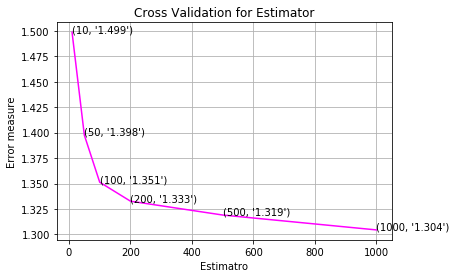

In [192]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_ab,c='magenta')
for i, txt in enumerate(np.round(cv_log_error_ab,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_ab[i]))
plt.grid()
plt.title("Cross Validation for Estimator")
plt.xlabel("Estimatro")
plt.ylabel("Error measure")
plt.show()

In [193]:
learn_rate = {'learning_rate': [0.001 , 0.01 , 0.1 , 1.0 , 1.3]}
folds = 5

In [194]:
ABC = AdaBoostClassifier(base_estimator=shallow_tree)
grid_search_lr = GridSearchCV(ABC, cv = folds , param_grid = learn_rate , return_train_score = True , n_jobs = -1)
grid_search_lr.fit(train_x_onehotEncoding , train_y)
print('Best parameter for max_depth: ',grid_search_lr.best_params_)

Best parameter for max_depth:  {'learning_rate': 0.01}


In [195]:
ABC = AdaBoostClassifier(base_estimator = shallow_tree , learning_rate = 0.01 , n_estimators = 700)
ABC.fit(train_x_onehotEncoding, train_y)
    
ccv_abc = CalibratedClassifierCV(ABC , method="sigmoid")
ccv_abc.fit(train_x_onehotEncoding, train_y)
        
y_pred_abc = ccv_abc.predict_proba(train_x_onehotEncoding)
print("The train log loss is:",log_loss(y_train, y_pred_abc, labels=ABC.classes_, eps=1e-15))

y_pred_abc = ccv_abc.predict_proba(cv_x_onehotEncoding)
print("The cross validation log loss is:",log_loss(y_cv, y_pred_abc, labels=ABC.classes_, eps=1e-15))

y_pred_abc = ccv_abc.predict_proba(test_x_onehotEncoding)
print("The test log loss is:",log_loss(y_test, y_pred_abc, labels=ABC.classes_, eps=1e-15))

The train log loss is: 1.2798213043500444
The cross validation log loss is: 1.4935923391822754
The test log loss is: 1.453931889477198


Log loss : 1.5222649919861708
Number of mis-classified points : 0.6033834586466166
-------------------- Confusion matrix --------------------


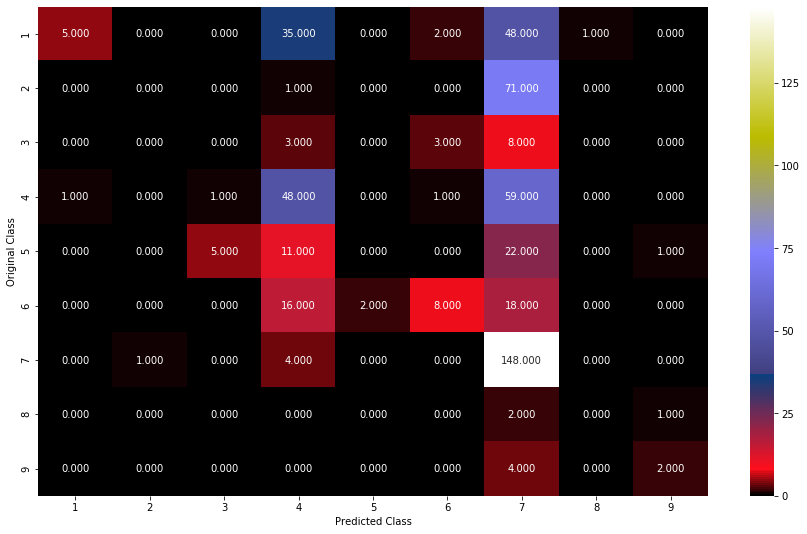

-------------------- Precision matrix (Columm Sum=1) --------------------


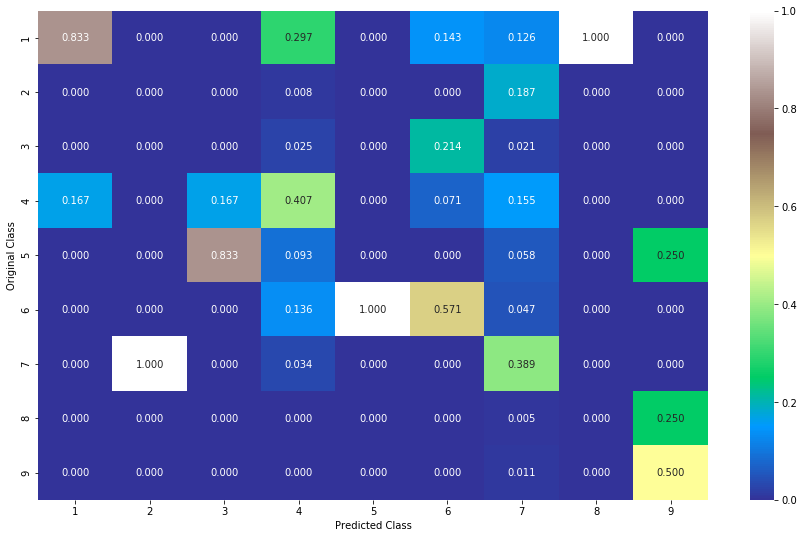

-------------------- Recall matrix (Row sum=1) --------------------


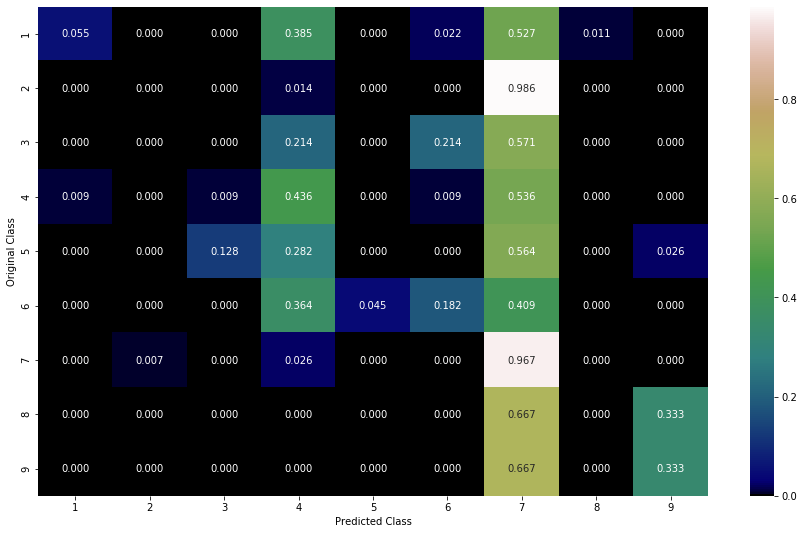

In [485]:
predict_and_plot_confusion_matrix(train_x_onehotEncoding, train_y,cv_x_onehotEncoding,cv_y, ABC)

### Interpretablity of Adaboost

In [251]:
test_point_index = 299
no_feature = 100

predicted_cls = ccv_abc.predict(test_x_onehotEncoding[test_point_index].reshape(1 , -1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_abc.predict_proba(test_x_onehotEncoding[test_point_index].reshape(1 , -1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-ABC.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[1.771e-01 5.370e-02 1.710e-02 1.813e-01 1.214e-01 3.245e-01 1.229e-01
  1.800e-03 2.000e-04]]
Actual Class : 6
--------------------------------------------------
0 Text feature [mutations] present in test data point [True]
2 Text feature [dna] present in test data point [True]
4 Text feature [new] present in test data point [True]
5 Text feature [protein] present in test data point [True]
7 Text feature [group] present in test data point [True]
9 Text feature [missense] present in test data point [True]
11 Text feature [brca1] present in test data point [True]
15 Text feature [family] present in test data point [True]
25 Text feature [predicted] present in test data point [True]
35 Text feature [variant] present in test data point [True]
36 Text feature [cancer] present in test data point [True]
39 Text feature [clinical] present in test data point [True]
50 Text feature [high] present in test data point [True]
54 Text feature [mutat

Adaboost time complexity is so high then other algorithm apply in this project.

# PCA

PCA is a tecnique to reduce dimension of a data.So our first work is to reduce the dimension of train,cv,test and then apply it to adaboost classifier for better perfomence.

In [239]:
from sklearn import decomposition
pca = decomposition.PCA()
spca = decomposition.SparsePCA()

In [248]:
spca.n_components = 2

sample_data_train = train_x_onehotEncoding
sample_data_train = sample_data_train.toarray()
train_spca = spca.fit_transform(sample_data_train)


sample_data_test = test_x_onehotEncoding
sample_data_test = sample_data_test.toarray()
test_spca = spca.fit_transform(sample_data_test)



sample_data_cv = cv_x_onehotEncoding
sample_data_cv = sample_data_cv.toarray()
cv_spca = spca.fit_transform(sample_data_cv)

In [250]:
print('Train Dimension after SPCA :' , train_spca.shape)
print('Test Dimension after SPCA :' , test_spca.shape)
print('CV Dimension after SPCA :' , cv_spca.shape)

Train Dimension after SPCA : (2124, 2)
Test Dimension after SPCA : (665, 2)
CV Dimension after SPCA : (532, 2)


Dimension is now 2 for every site.Now apply ADABoost classifier.

In [253]:
cv_log_error_ab_pca = []
for n_est in estimators:
    print("n_estimator: " , n_est)
    ABC_pca = AdaBoostClassifier(base_estimator=shallow_tree  , n_estimators = n_est)
    ABC_pca.fit(sample_data_train , train_y)
    
    ccv_ab_pca = CalibratedClassifierCV(ABC_pca, method="sigmoid")
    ccv_ab_pca.fit(sample_data_train , train_y)
    
    y_pred_ab = ccv_ab_pca.predict_proba(sample_data_cv)
    
    cv_log_error_ab_pca.append(log_loss(cv_y, y_pred_ab, labels=ABC_pca.classes_ , eps=1e-15))
    print("Log Loss :",log_loss(cv_y , y_pred_ab)) 

n_estimator:  100
Log Loss : 1.5093474308565675
n_estimator:  250
Log Loss : 1.4006036296670714
n_estimator:  400
Log Loss : 1.3613114602031426
n_estimator:  550
Log Loss : 1.3239462971398184
n_estimator:  700
Log Loss : 1.3204751279628162
n_estimator:  850
Log Loss : 1.3060562508712585


### In my machine it take 18-hours to complete the above statement/cell.I have 8GB RAM and core-i5 processor.So if u have very strong pc then try this.Otherwise skip this part.

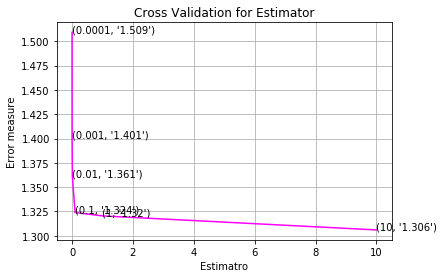

In [254]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_ab_pca,c='magenta')
for i, txt in enumerate(np.round(cv_log_error_ab_pca,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_ab_pca[i]))
plt.grid()
plt.title("Finding best estimator")
plt.xlabel("Estimator")
plt.ylabel("Error measure")
plt.show()

In [ ]:
ABC = AdaBoostClassifier(base_estimator=shallow_tree)
grid_search_lr = GridSearchCV(ABC, cv = folds , param_grid = learn_rate , return_train_score = True , n_jobs = -1)
grid_search_lr.fit(sample_data_train , train_y)
print('Best parameter for max_depth: ',grid_search_lr.best_params_)

In [ ]:
ABC_pca = AdaBoostClassifier(base_estimator = shallow_tree , learning_rate = 0.01 , n_estimators = 850)
ABC_pca.fit(sample_data_train , train_y)
    
ccv_abc_pca = CalibratedClassifierCV(ABC_pca , method="sigmoid")
ccv_abc_pca.fit(sample_data_train , train_y)
        
y_pred_abc_pca = ccv_abc_pca.predict_proba(sample_data_train)
print("The train log loss is:",log_loss(y_train, y_pred_abc_pca , labels=ABC_pca.classes_, eps=1e-15))

y_pred_abc_pca = ccv_abc_pca.predict_proba(sample_data_cv)
print("The cross validation log loss is:",log_loss(y_cv, y_pred_abc_pca, labels=ABC_pca.classes_, eps=1e-15))

y_pred_abc_pca = ccv_abc_pca.predict_proba(sample_data_test)
print("The test log loss is:",log_loss(y_test, y_pred_abc_pca, labels=ABC_pca.classes_, eps=1e-15))

### Interpretability of Adaboost using pca

In [ ]:
test_point_index = 299
no_feature = 100

predicted_cls = ccv_abc_pca.predict(sample_data_test[test_point_index].reshape(1 , -1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_abc_pca.predict_proba(sample_data_test[test_point_index].reshape(1 , -1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-ABC_pca.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

### Best no. of features by SPCA

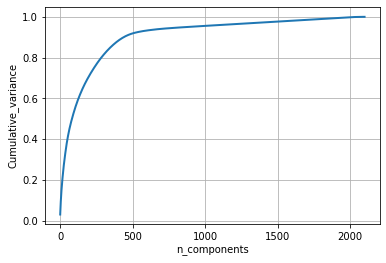

In [261]:
pca.n_components = 2100
spca_data = pca.fit_transform(sample_data_train)

percent_var_expalined = pca.explained_variance_/np.sum(pca.explained_variance_)

cum_var_explained = np.cumsum(percent_var_expalined)

plt.figure(1 , figsize = (6,4))
plt.clf()
plt.plot(cum_var_explained , linewidth = 2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_variance')
plt.show()

# XGBOOST

### Response-encoding

In [487]:
from xgboost import XGBClassifier

In [488]:
xgb_re = XGBClassifier(random_state = 31)
xgb_re.fit(train_x_responseEncoding, train_y)
    
ccv_xgb_re = CalibratedClassifierCV(xgb_re , method="sigmoid")
ccv_xgb_re.fit(train_x_responseEncoding, train_y)
        
y_pred_rf_re = ccv_xgb_re.predict_proba(train_x_responseEncoding)
print("The train log loss is:",log_loss(y_train, y_pred_rf_re, labels=rf_re.classes_, eps=1e-15))

y_pred_rf_re = ccv_xgb_re.predict_proba(cv_x_responseEncoding)
print("The cross validation log loss is:",log_loss(y_cv, y_pred_rf_re, labels=rf_re.classes_, eps=1e-15))

y_pred_rf_re = ccv_xgb_re.predict_proba(test_x_responseEncoding)
print("The test log loss is:",log_loss(y_test, y_pred_rf_re, labels=rf_re.classes_, eps=1e-15))

The train log loss is: 0.03886097281686818
The cross validation log loss is: 1.511669715269639
The test log loss is: 1.5234252027569808


Log loss : 1.511669715269639
Number of mis-classified points : 0.5075187969924813
-------------------- Confusion matrix --------------------


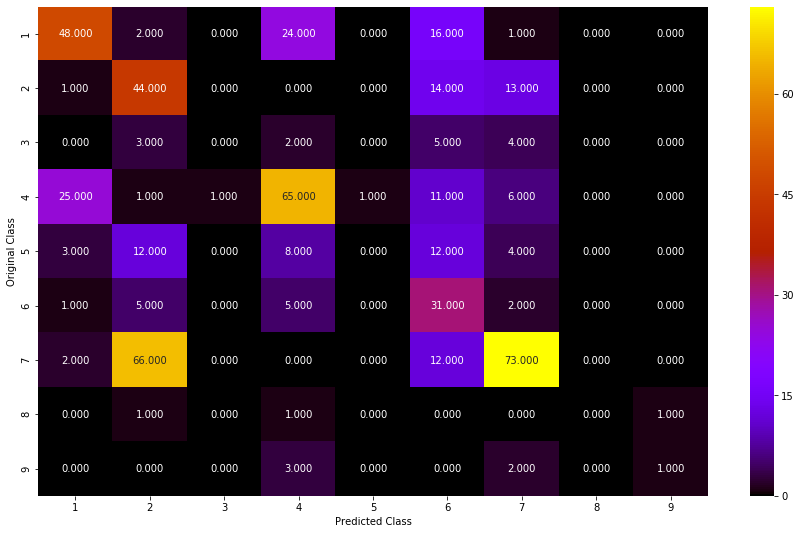

-------------------- Precision matrix (Columm Sum=1) --------------------


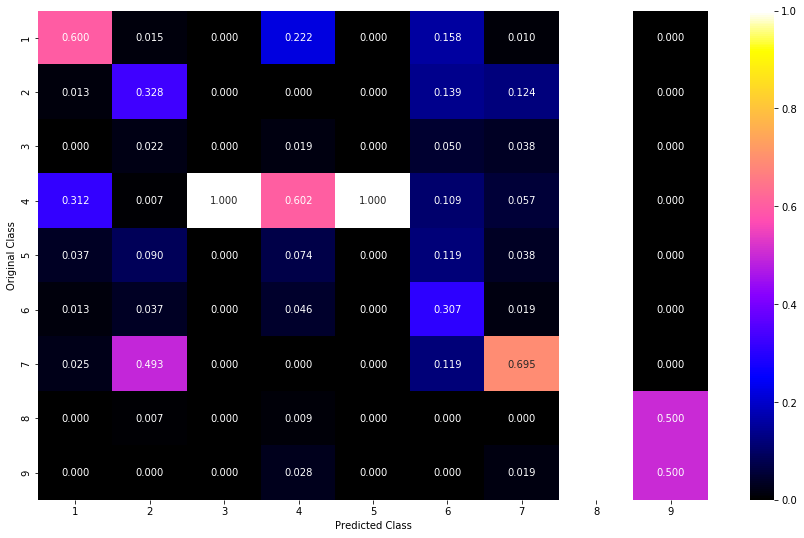

-------------------- Recall matrix (Row sum=1) --------------------


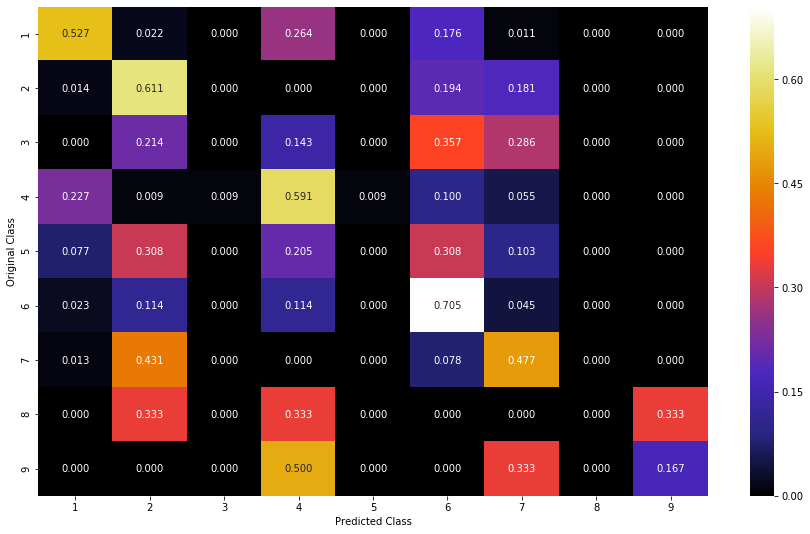

In [489]:
predict_and_plot_confusion_matrix(train_x_responseEncoding, train_y,cv_x_responseEncoding,cv_y, xgb_re)

### interpretability of one-hot-encoder

In [490]:
test_point_index = 99
no_feature = 100

predicted_cls = ccv_xgb_re.predict(test_x_responseEncoding[test_point_index].reshape(1 , -1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_xgb_re.predict_proba(test_x_responseEncoding[test_point_index].reshape(1 , -1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-xgb_re.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 6
Predicted Class Probabilities: [[0.2096 0.1053 0.0497 0.1036 0.0556 0.2935 0.1047 0.0417 0.0362]]
Actual Class : 1
--------------------------------------------------
Out of the top  100  features  0 are present in query point


In [491]:
test_point_index = 49
no_feature = 100

predicted_cls = ccv_xgb_re.predict(test_x_responseEncoding[test_point_index].reshape(1 , -1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(ccv_xgb_re.predict_proba(test_x_responseEncoding[test_point_index].reshape(1 , -1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-xgb_re.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.4109 0.0792 0.0313 0.275  0.03   0.0479 0.0697 0.0318 0.0243]]
Actual Class : 4
--------------------------------------------------
Out of the top  100  features  0 are present in query point


In XGBOOST classifer there is a huge over-fitting problem in response-encoding and also there is Prediction Mis-classificaiton problem.

# STACKING CLASSIFIER

### One-hot-encoder

In [492]:
sgd_stack1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
sgd_stack1.fit(train_x_onehotEncoding, train_y)

ccv_sgd_stack1 = CalibratedClassifierCV(sgd_stack1 , method="sigmoid")

sgd_stack2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
sgd_stack2.fit(train_x_onehotEncoding, train_y)

ccv_sgd_stack2 = CalibratedClassifierCV(sgd_stack2, method="sigmoid")


sgd_stack3 = MultinomialNB(alpha=0.001)
sgd_stack3.fit(train_x_onehotEncoding, train_y)

ccv_sgd_stack3 = CalibratedClassifierCV(sgd_stack3, method="sigmoid")

In [493]:
ccv_sgd_stack1.fit(train_x_onehotEncoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, ccv_sgd_stack1.predict_proba(cv_x_onehotEncoding))))

ccv_sgd_stack3.fit(train_x_onehotEncoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, ccv_sgd_stack3.predict_proba(cv_x_onehotEncoding))))

ccv_sgd_stack2.fit(train_x_onehotEncoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, ccv_sgd_stack2.predict_proba(cv_x_onehotEncoding))))
print("-"*50)


alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999

for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[ccv_sgd_stack1, ccv_sgd_stack2, ccv_sgd_stack3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotEncoding, train_y)
    
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotEncoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotEncoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.05
Naive Bayes : Log Loss: 1.27
Support vector machines : Log Loss: 1.69
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.820
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.741
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.376
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.164
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.374
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.614


In [507]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[ccv_sgd_stack1, ccv_sgd_stack2, ccv_sgd_stack3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotEncoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotEncoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotEncoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotEncoding))
print("Log loss (test) on the stacking classifier :",log_error)


print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotEncoding)- test_y))/test_y.shape[0])

Log loss (train) on the stacking classifier : 0.4723229832519101
Log loss (CV) on the stacking classifier : 1.1643956363663237
Log loss (test) on the stacking classifier : 1.1797777433556877
Number of missclassified point : 0.3894736842105263


-------------------- Confusion matrix --------------------


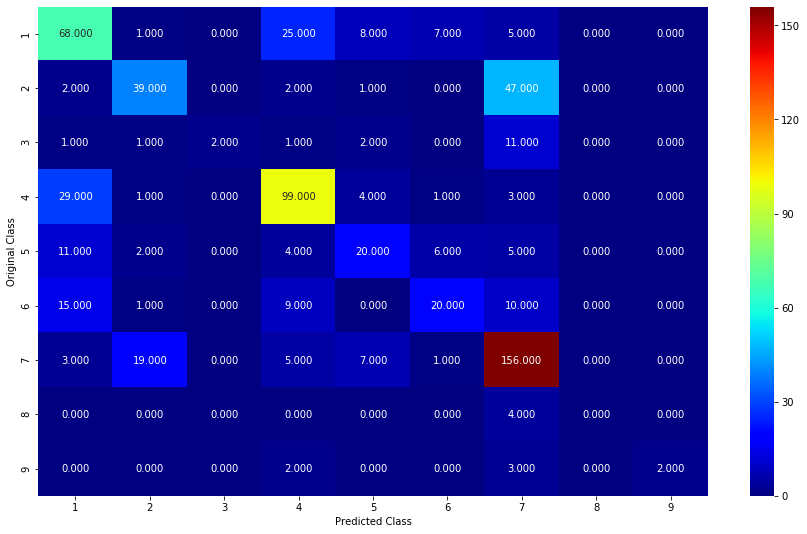

-------------------- Precision matrix (Columm Sum=1) --------------------


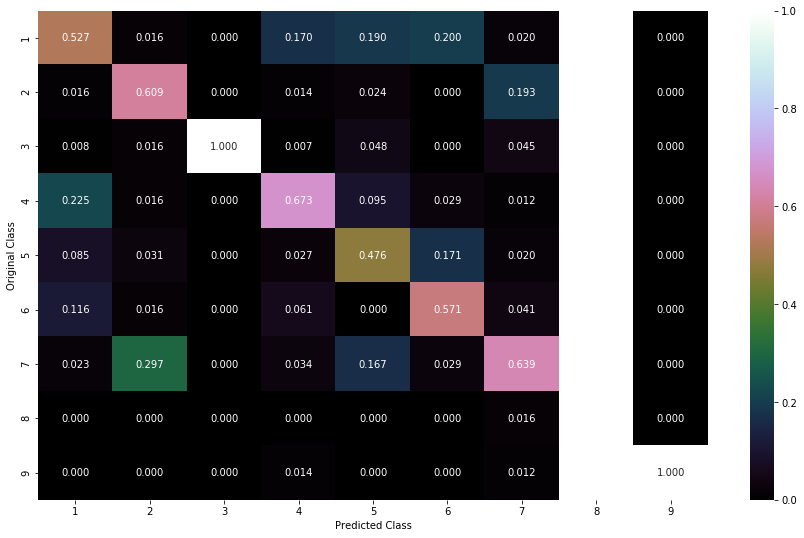

-------------------- Recall matrix (Row sum=1) --------------------


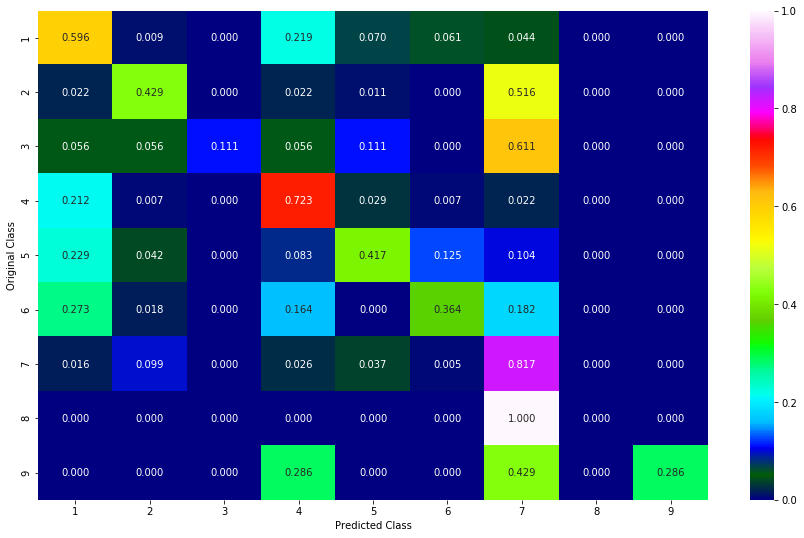

In [510]:
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotEncoding))

### Interpretablity of Stacking Classifier

In [495]:
test_point_index = 1
no_feature = 100

predicted_cls = sclf.predict(test_x_onehotEncoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sclf.predict_proba(test_x_onehotEncoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0322 0.0222 0.0201 0.8029 0.0253 0.019  0.0661 0.0045 0.0079]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point


In [496]:
test_point_index = 199
no_feature = 100

predicted_cls = sclf.predict(test_x_onehotEncoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sclf.predict_proba(test_x_onehotEncoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0119 0.0302 0.0114 0.0109 0.0134 0.0123 0.9032 0.0026 0.0042]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point


In [497]:
test_point_index = 301
no_feature = 500

predicted_cls = sclf.predict(test_x_onehotEncoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sclf.predict_proba(test_x_onehotEncoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0422 0.4903 0.0383 0.068  0.0497 0.0426 0.2455 0.0086 0.0148]]
Actual Class : 2
--------------------------------------------------
Out of the top  500  features  0 are present in query point


### Response-encoding

In [513]:
sgd_stack1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
sgd_stack1.fit(train_x_responseEncoding, train_y)

ccv_sgd_stack1 = CalibratedClassifierCV(sgd_stack1 , method="sigmoid")

sgd_stack2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
sgd_stack2.fit(train_x_responseEncoding, train_y)

ccv_sgd_stack2 = CalibratedClassifierCV(sgd_stack2, method="sigmoid")


sgd_stack3 = MultinomialNB(alpha=0.001)
sgd_stack3.fit(train_x_responseEncoding, train_y)

ccv_sgd_stack3 = CalibratedClassifierCV(sgd_stack3, method="sigmoid")

In [514]:
ccv_sgd_stack1.fit(train_x_responseEncoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, ccv_sgd_stack1.predict_proba(cv_x_responseEncoding))))

ccv_sgd_stack3.fit(train_x_responseEncoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, ccv_sgd_stack3.predict_proba(cv_x_responseEncoding))))

ccv_sgd_stack2.fit(train_x_responseEncoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, ccv_sgd_stack2.predict_proba(cv_x_responseEncoding))))
print("-"*50)


alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999

for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[ccv_sgd_stack1, ccv_sgd_stack2, ccv_sgd_stack3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_responseEncoding, train_y)
    
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_responseEncoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_responseEncoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.22
Naive Bayes : Log Loss: 1.29
Support vector machines : Log Loss: 1.18
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.819
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.737
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.443
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.221
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.172
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.166


In [515]:
lr = LogisticRegression(C=0.1)

sclf = StackingClassifier(classifiers=[ccv_sgd_stack1, ccv_sgd_stack2, ccv_sgd_stack3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_responseEncoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_responseEncoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_responseEncoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_responseEncoding))
print("Log loss (test) on the stacking classifier :",log_error)

Log loss (train) on the stacking classifier : 1.0935441400386636
Log loss (CV) on the stacking classifier : 1.2209285029403976
Log loss (test) on the stacking classifier : 1.184071066921836


Number of missclassified point : 0.3954887218045113
-------------------- Confusion matrix --------------------


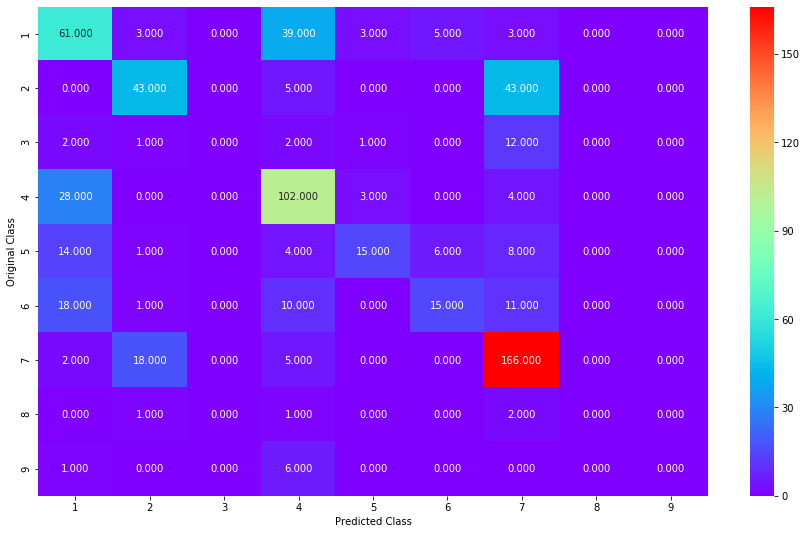

-------------------- Precision matrix (Columm Sum=1) --------------------


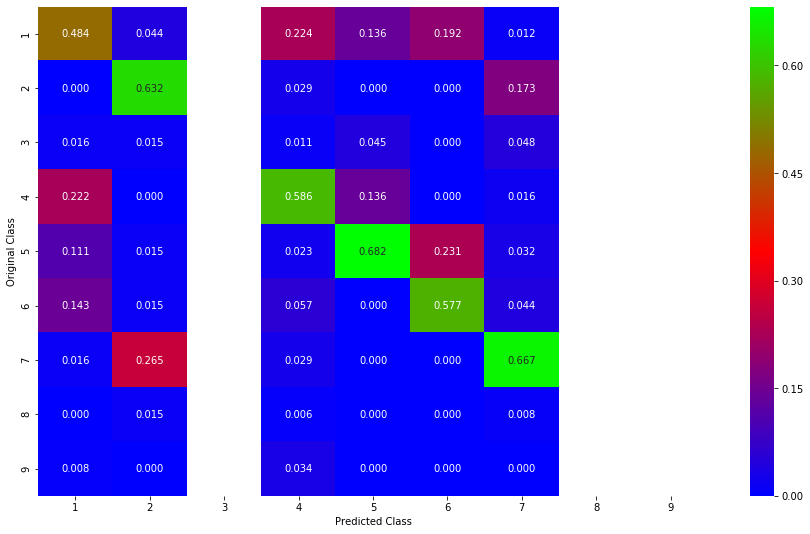

-------------------- Recall matrix (Row sum=1) --------------------


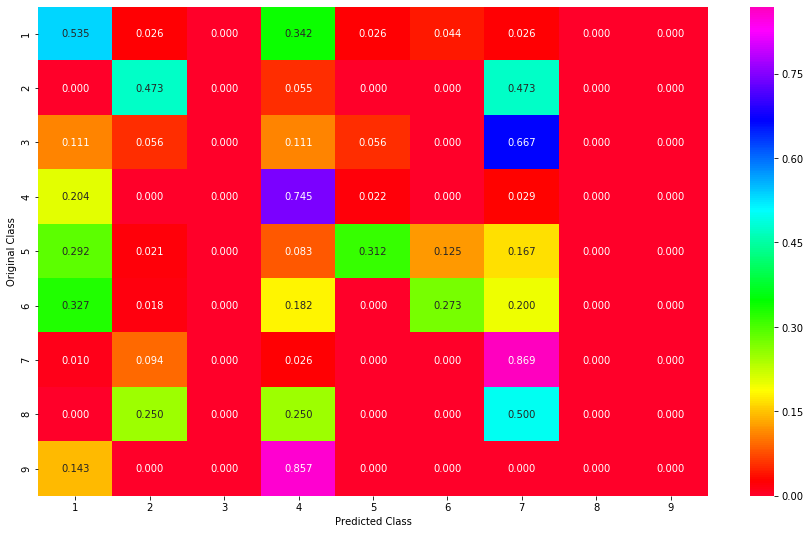

In [504]:
print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_responseEncoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_responseEncoding))

### Interpretability with response-encoding

In [516]:
test_point_index = 1
no_feature = 100

predicted_cls = sclf.predict(test_x_responseEncoding[test_point_index].reshape(1 , -1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sclf.predict_proba(test_x_responseEncoding[test_point_index].reshape(1 , -1)),4))
print("Actual Class :", test_y[test_point_index])
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0141 0.1946 0.0222 0.0209 0.0297 0.0332 0.6745 0.0041 0.0066]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point


# Maximum Voting Classifier

### One-hot-encoding

In [518]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', ccv_sgd_stack1), ('svc', ccv_sgd_stack2), ('rf', ccv_sgd_stack3)], voting='soft')
vclf.fit(train_x_onehotEncoding, train_y)

print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotEncoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotEncoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotEncoding)))

print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotEncoding)- test_y))/test_y.shape[0])

Log loss (train) on the VotingClassifier : 0.8755597353322351
Log loss (CV) on the VotingClassifier : 1.2254151596680543
Log loss (test) on the VotingClassifier : 1.2589135130906801
Number of missclassified point : 0.3924812030075188


-------------------- Confusion matrix --------------------


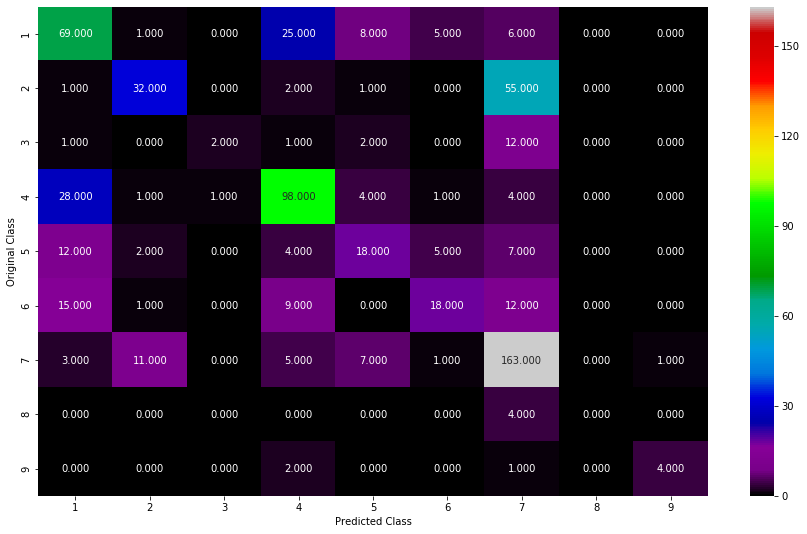

-------------------- Precision matrix (Columm Sum=1) --------------------


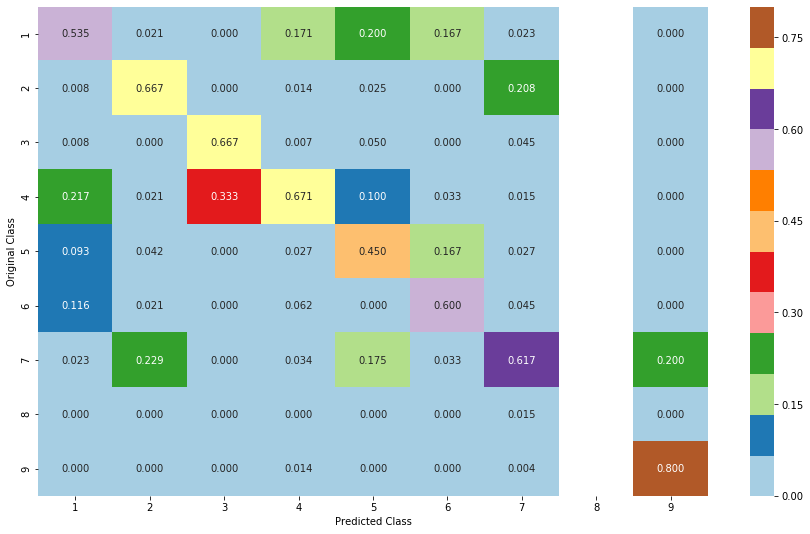

-------------------- Recall matrix (Row sum=1) --------------------


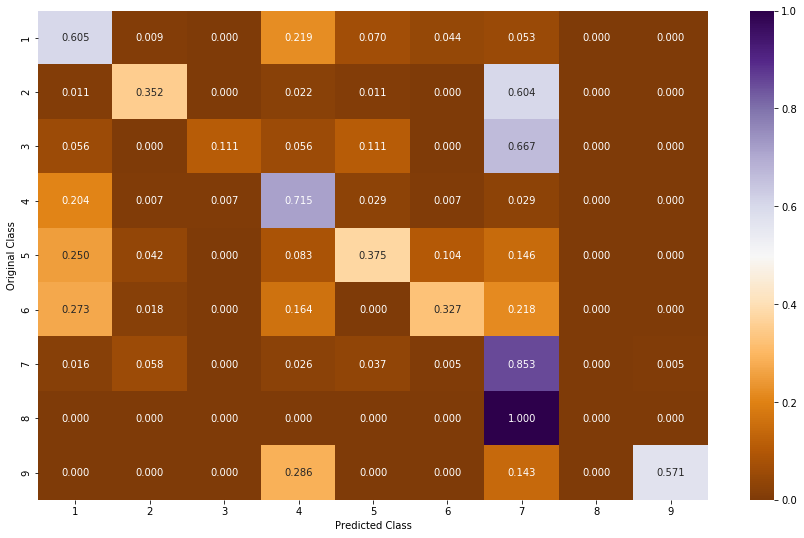

In [520]:
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotEncoding))

### Response-Encoding

In [521]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', ccv_sgd_stack1), ('svc', ccv_sgd_stack2), ('rf', ccv_sgd_stack3)], voting='soft')
vclf.fit(train_x_responseEncoding, train_y)

print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_responseEncoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_responseEncoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_responseEncoding)))

print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_responseEncoding)- test_y))/test_y.shape[0])

Log loss (train) on the VotingClassifier : 1.098704688513209
Log loss (CV) on the VotingClassifier : 1.2083253015702877
Log loss (test) on the VotingClassifier : 1.1825920549446056
Number of missclassified point : 0.39398496240601505


-------------------- Confusion matrix --------------------


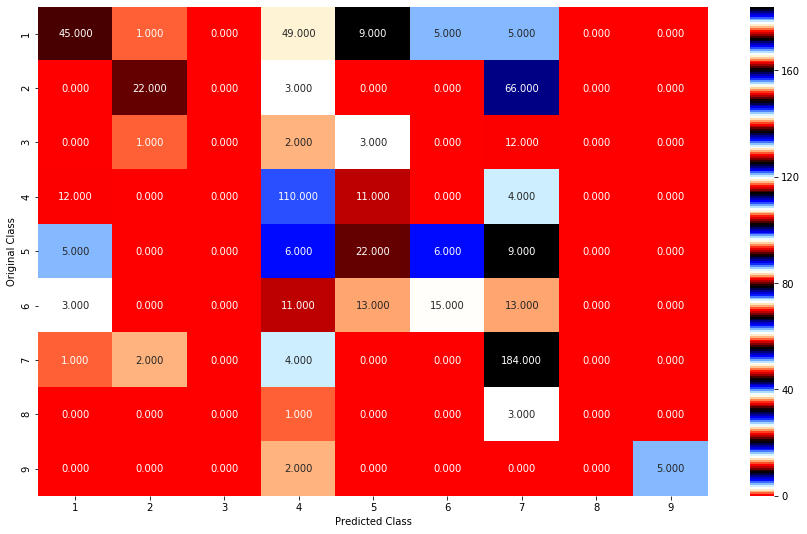

-------------------- Precision matrix (Columm Sum=1) --------------------


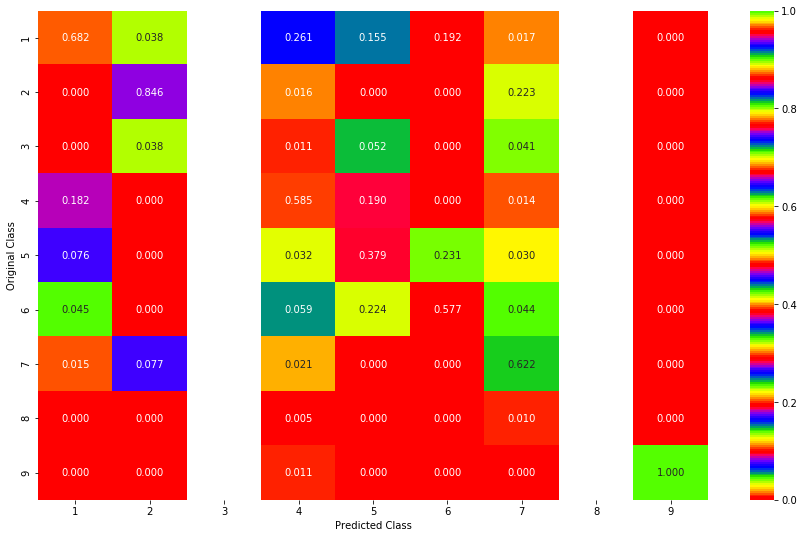

-------------------- Recall matrix (Row sum=1) --------------------


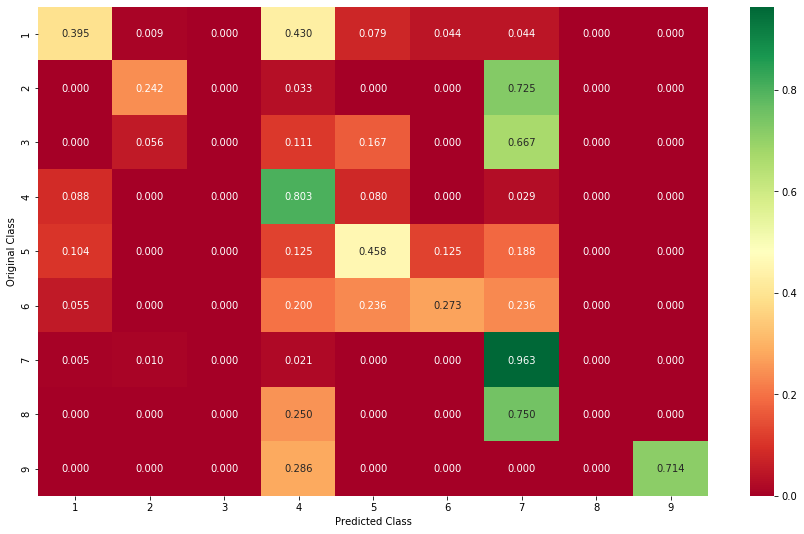

In [525]:
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_responseEncoding))

# Table for all algorithm and their Accuracy.

In [526]:
dataframe = {
    'Algorithm': ['Logistic Regression with balancing(one-hot-encoding)' , 'Logistic Regression with balancing(response-encoding)' , 'LR without class balancing(one-hot-encoding)' , 'LR without class balancing(response-encoding)' , 'KNN(one-hot-encoding)' , 'KNN(response-encoding)' , 'Naive Bayes(one-hot-encoding)' , 'NB(response-encoding)' , 'SVM(one-hot-encoding)' , 'Random-Forest(one-hot-encoding)' , 'RF(response-encoding)' , 'ADABoost(one-hot-encoding)' , 'XGBoost(response-encoding)' , 'Stacking-Classifier(one-hot-encoding)' , 'Stacking-Classifier(response-encoding)' , 'Maximum-Voting-Classifier(one-hot-encoding)' , 'Maximum-voting-classifier(response-encdoing)'], 
    'Train': [0.50 , 1.32 , 0.49 , 1.27 , 0.88 , 0.76 , 0.67 , 1.20 , 1.68 , 1.08 , 0.065 , 1.27 , 0.03 , 0.47 , 1.07 , 0.86 , 1.08],
    'Test': [1.02 , 1.34 , 1.01 , 1.30 , 1.14 , 1.08 , 1.17 , 1.24 , 1.68 , 1.28 , 1.34 , 1.45 , 1.68 , 1.01 , 1.15 , 1.19 , 1.17],
    'Cv' : [1.13 , 1.40 , 1.14 , 1.36 , 1.12 , 1.13 , 1.25 , 1.31 , 1.72 , 1.37 , 1.37 , 1.49 , 1.72 , 1.23 , 1.26 , 1.27 , 1.25],
    'Misclassified' : [37.03 , 42.1 , 37.2 , 42.2 , 40.2 , 40.0 , 39.2 , 47.5 , 38.5 , 55.5 , 47.7 , 57.5 , 63.5 , 36.8 , 39.5 , 34.7 , 38.1]
}

In [527]:
r = pd.DataFrame(dataframe , columns = ['Algorithm' , 'Train' , 'Test' , 'Cv' , 'Misclassified'])

In [528]:
r

,Algorithm,Train,Test,Cv,Misclassified
0,Logistic Regression with balancing(one-hot-enc...,0.500,1.02,1.13,37.03
1,Logistic Regression with balancing(response-en...,1.320,1.34,1.40,42.10
2,LR without class balancing(one-hot-encoding),0.490,1.01,1.14,37.20
3,LR without class balancing(response-encoding),1.270,1.30,1.36,42.20
4,KNN(one-hot-encoding),0.880,1.14,1.12,40.20
5,KNN(response-encoding),0.760,1.08,1.13,40.00
6,Naive Bayes(one-hot-encoding),0.670,1.17,1.25,39.20
7,NB(response-encoding),1.200,1.24,1.31,47.50
8,SVM(one-hot-encoding),1.680,1.68,1.72,38.50
9,Random-Forest(one-hot-encoding),1.080,1.28,1.37,55.50


Above table is basically the alogrithm applied in this project and their train,test,cv,and misclassified result.All algorithm are different from each other.Some have very lowest train score but their test and cv score is very hight,this leads it to a overfiting algorithm.Finally it can be said that Stacking-Classifier with one-hot-encoding have the lowest from others and also have very low misclassified accuracy.